In [304]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import statsmodels.api as sm

from numpy import asarray
from sklearn.preprocessing import MinMaxScaler

from dateutil.relativedelta import relativedelta

pd.set_option('display.max_row', 1000)
pd.set_option('display.max_columns', 50)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

from IPython.display import HTML
from IPython.core.interactiveshell import InteractiveShell
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pickle
#pd.reset_option('display.float_format')

In [305]:
data = pd.read_csv("./data/kc_house_data.csv")

# Misc Functions

In [306]:

def checkForColinearity(df_ColsToCheck):
    df=df_ColsToCheck.corr().abs().stack().reset_index().sort_values(0, ascending=False)

    #zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
    df['pairs'] = list(zip(df.level_0, df.level_1))

    #set index to pairs
    df.set_index(['pairs'], inplace = True)

    #drop level columns
    df.drop(columns=['level_1', 'level_0'], inplace = True)

    #rename correlation column as cc rather than 0
    df.columns = ['cc']

    #drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
    df.drop_duplicates(inplace=True)
    df = df[(df.cc>.70) & (df.cc <1)]
    return df

def correlation_heatmap(df):
    _,ax=plt.subplots(figsize=(60,30))
    colormap=sns.diverging_palette(220,10,as_cmap=True)
    sns.heatmap(df.corr(),annot=True,cmap=colormap)

def checkForVIF(df_ColsToCheck):
#     X = df[x_cols]
    vif = [variance_inflation_factor(df_ColsToCheck.values, i) for i in range(df_ColsToCheck.shape[1])]
    vifresults = list(zip(df_ColsToCheck.columns, vif))
    return vifresults

def scaleData_min_max (df_continuous):
    scaler = MinMaxScaler()
    # transform data
    scaler_a = MinMaxScaler().fit(df_continuous)
    scaler_ = scaler.fit_transform(df_continuous)
    scaled_df = pd.DataFrame(scaler_, columns=df_continuous.columns)
    scaled_df_no_index = scaled_df.reset_index(drop=True)
    #
    return scaled_df_no_index, scaler_a

# Preprocessing

Ensure No Missing Values

waterfront      2376
view              63
yr_renovated    3842
dtype: int64


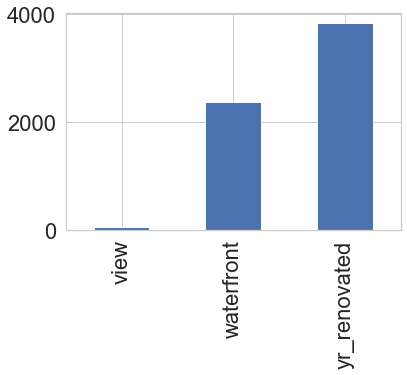

In [307]:
missing = data.isnull().sum()
missing = missing[missing > 0]
print (missing)
missing.sort_values(inplace=True)
missing.plot.bar();

In [308]:
listofBaseColumns = data.columns
listofBaseColumns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

### Dealing with Missing Values

In [309]:
#fill In Waterfront and View Nulls
data_No_NAs = data
data_No_NAs['waterfront'].fillna(data['waterfront'].mode()[0], inplace=True)
data_No_NAs['view'].fillna(data['view'].mode()[0], inplace=True)


#fill In Year Renovated and insert "Age of Home" (Today - Year Built) and "Years Since Renovated"
data_No_NAs["yr_renovated"].fillna(0, inplace=True)
# data_No_NAs["yr_renovated"]  = data_No_NAs.apply(lambda row : (row['yr_built']) if row["yr_renovated"] == 0 else row["yr_renovated"], axis=1)

#handle "?" in the sqrt basement column
data_No_NAs["sqft_basement"]  = data_No_NAs.apply(lambda row : 0 if row["sqft_basement"] == "?" else row["sqft_basement"], axis=1)
data_No_NAs["sqft_basement"] = data_No_NAs["sqft_basement"].astype('float')


### Add Potential Interesting Columns using basedata

In [310]:
#Any relationship if renovated
data_No_NAs["If_renovated"]  = data_No_NAs.apply(lambda row : 1 if row["yr_renovated"] > 0 else 0, axis=1)


# Any relatinship with age of home
data_No_NAs["AgeOfHome"] = (2020 - data_No_NAs["yr_built"])

# Is there any relationship with zipcode
data_No_NAs["zipcode_str"] = data_No_NAs["zipcode"].astype('str')
data_No_NAs['ZipFirst3'] = data_No_NAs["zipcode_str"].str[:3]
data_No_NAs['ZipFirst3_int'] = data_No_NAs["ZipFirst3"].astype('int')
data_No_NAs = data_No_NAs.drop("zipcode_str", axis=1) 

# Is there any relationship with the month of sale?
data_No_NAs['salesyear'] = pd.DatetimeIndex(data_No_NAs['date']).year
data_No_NAs['sls_month'] = pd.DatetimeIndex(data_No_NAs['date']).month
                                                 
                                                 
# Create new variables Rooms and sqft_Above_Combo given high vifs
data_No_NAs["ttl_rooms"] = data_No_NAs['bedrooms']*data_No_NAs['bathrooms']

In [311]:
df_check2 = data_No_NAs.loc[data_No_NAs.waterfront ==1]
len(df_check2)

146

In [312]:
data_No_NAs.head()

id        date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  If_renovated  AgeOfHome ZipFirst3  ZipFirst3_int  salesyear  sls_month  ttl_rooms
0  7129300520  10/13/2014  221900.0         3       1.00         1180      5650     1.0         0.0   0.0          3      7        1180            0.0      1955           0.0    98178  47.5112 -122.257           1340        5650             0         65       981            981       2014         10       3.00
1  6414100192   12/9/2014  538000.0         3       2.25         2570      7242     2.0         0.0   0.0          3      7        2170          400.0      1951        1991.0    98125  47.7210 -122.319           1690        7639             1         69       981            981       2014         12       6.75
2  5631500400   2/25/2015  180000.0         2       1.00          770     10000     1.0         0.0   0.0          3      6         770            0.0      1933           0.0    98028  47.7379 -122.233           2720        8062             0         87       980            980       2015          2       2.00
3  2487200875   12/9/2014  604000.0         4       3.00         1960      5000     1.0         0.0   0.0          5      7        1050          910.0      1965           0.0    98136  47.5208 -122.393           1360        5000             0         55       981            981       2014         12      12.00
4  1954400510   2/18/2015  510000.0         3       2.00         1680      8080     1.0         0.0   0.0          3      8        1680            0.0      1987           0.0    98074  47.6168 -122.045           1800        7503             0         33       980            980       2015          2       6.00

In [313]:
missing = data_No_NAs.isnull().sum()
missing

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
If_renovated     0
AgeOfHome        0
ZipFirst3        0
ZipFirst3_int    0
salesyear        0
sls_month        0
ttl_rooms        0
dtype: int64

In [314]:
data_No_NAs.view.value_counts()

0.0    19485
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

In [315]:
data_No_NAs.condition.value_counts()

3    14020
4     5677
5     1701
2      170
1       29
Name: condition, dtype: int64

In [316]:
data_No_NAs.sls_month.value_counts()

5     2414
4     2229
7     2211
6     2178
8     1939
10    1876
3     1875
9     1771
12    1470
11    1409
2     1247
1      978
Name: sls_month, dtype: int64

In [317]:
data_No_NAs.ZipFirst3_int.value_counts()

980    12624
981     8973
Name: ZipFirst3_int, dtype: int64

In [318]:
data_No_NAs.grade.value_counts()

7     8974
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
13      13
3        1
Name: grade, dtype: int64

# <u> <font color='red'>Model 1 Dataset</font></u>

##    Creating Inital Dataset

### Looking for Linear Relationships, Drop Features With Low Relationship, Scale

### Transform target and remove outliers to improve linearity

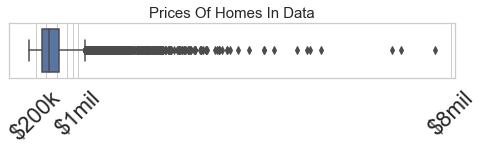

In [319]:
sns.set_style('whitegrid')
fig,ax=plt.subplots(1,1,figsize=(8,1))
plt.title('Prices Of Homes In Data', fontsize=15)
sns.boxplot(x=data_No_NAs['price'], labels=None)
# sns.boxplot(x=data_No_NAs['price'],ax=ax[1])
# _ , axes = plt.subplots(1, 1, figsize=(15,10))
# sns.boxplot(x=data['bathrooms'],y=data['price'])
plt.xticks(ticks=(200000, 400000, 600000, 800000, 900000, 1000000, 8000000), 
           labels= ('$200k', '', '', '',
                    '', '$1mil', '$8mil'))
# plt.xlabel('Price Of Home', fontsize=15)
plt.setp(ax.get_xticklabels(), rotation=45)
ax.set_xlabel('')
plt.show();

In [320]:
q_high = data_No_NAs['price'].quantile(.75)
q_low = data_No_NAs['price'].quantile(.25)
print(f' Lower Range - ${q_low} , Upper Range - ${q_high}')

 Lower Range - $322000.0 , Upper Range - $645000.0


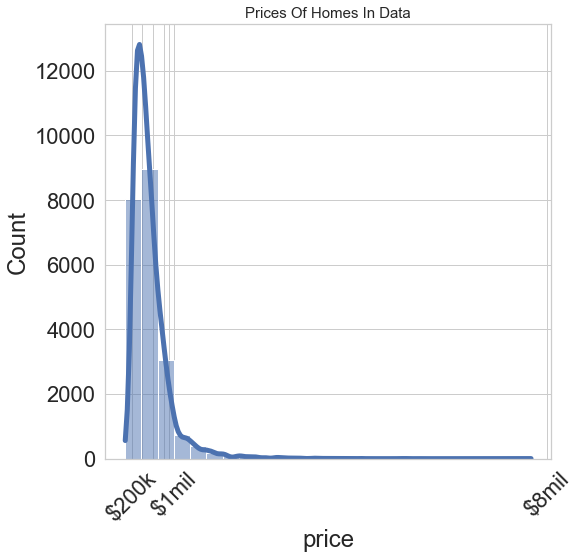

In [321]:
sns.set_style('whitegrid')
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
plt.title('Prices Of Homes In Data', fontsize=15)
sns.histplot(x= "price",
             data=data_No_NAs,
             bins=25,
             kde=True,
             line_kws={"linewidth":5}, ax=ax, )
plt.xticks(ticks=(200000, 400000, 600000, 800000, 900000, 1000000, 8000000), 
           labels= ('$200k', '', '', '',
                    '', '$1mil', '$8mil'))
# plt.xlabel('Price Of Home', fontsize=15)
plt.setp(ax.get_xticklabels(), rotation=45)

plt.show()

Given Heavy skew right, going to log transform and then drop outliers prices based on log transformation

In [322]:
data_No_NAs["log_price"] = np.log(data_No_NAs['price'])

<ipython-input-323-2db5c8e7d4c8>:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


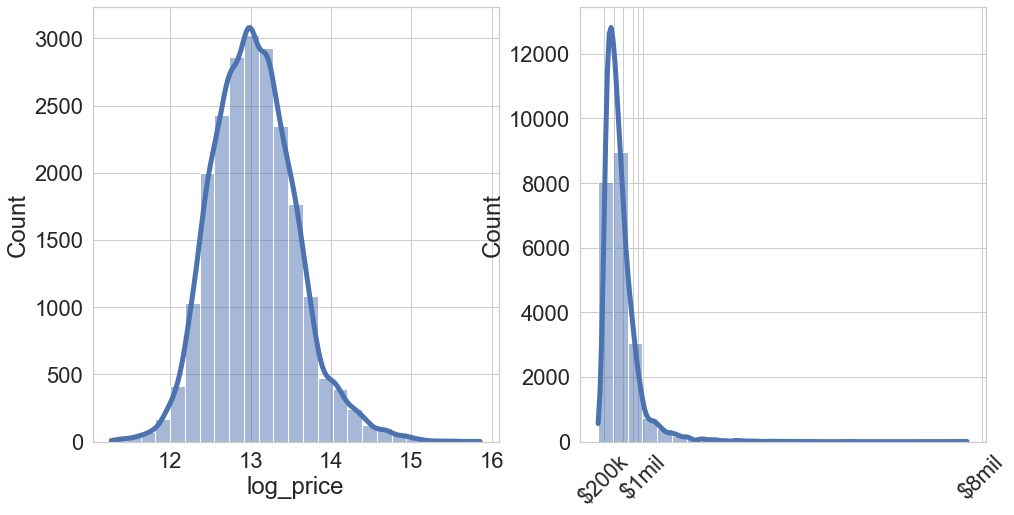

In [323]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

# fig = plt.figure(figsize = (8,8))

sns.histplot(data_No_NAs['log_price'], ax=ax, bins=25,
             kde=True,
             line_kws={"linewidth":5})

plt.xticks(ticks=(200000, 400000, 600000, 800000, 900000, 1000000, 8000000), 
                 labels= ('$200k', '', '', '',
                    '', '$1mil', '$8mil'), rotation=45)
plt.xlabel('', fontsize=15)

# plt.set(ax.get_xticklabels(), rotation=45)
# ax.set_xlabel('')

sns.histplot(data_No_NAs['price'], ax=ax2, bins=25,
             kde=True,
             line_kws={"linewidth":5})

plt.xticks(ticks=(200000, 400000, 600000, 800000, 900000, 1000000, 8000000), 
                 labels= ('$200k', '', '', '',
                    '', '$1mil', '$8mil'), rotation=45)
plt.xlabel('', fontsize=15)
fig.show()

Target feature now looks more normalized, now drop outlines

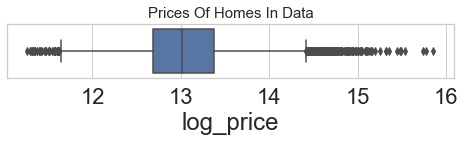

In [324]:
sns.set_style('whitegrid')
fig,ax=plt.subplots(1,1,figsize=(8,1))
plt.title('Prices Of Homes In Data', fontsize=15)
sns.boxplot(x=data_No_NAs['log_price'], labels=None)
# sns.boxplot(x=data_No_NAs['price'],ax=ax[1])
# _ , axes = plt.subplots(1, 1, figsize=(15,10))
# sns.boxplot(x=data['bathrooms'],y=data['price'])
# plt.xticks(ticks=(200000, 400000, 600000, 800000, 900000, 1000000, 8000000), 
#            labels= ('$200k', '', '', '',
#                     '', '$1mil', '$8mil'))
# # plt.xlabel('Price Of Home', fontsize=15)
# plt.setp(ax.get_xticklabels(), rotation=45)
# ax.set_xlabel('')
plt.show();

In [325]:
# lower = 250000
# upper = 800000
# 12.409013489526863
# 13.695600261291716
# 244999.99999999983
# 886999.9999999995
q_low = data_No_NAs['log_price'].quantile(0.1)
q_high = data_No_NAs['log_price'].quantile(0.9)

# print(Q1)
# print(Q3)
# np.exp(q_high)
# print(np.exp(Q1))
# print(np.exp(Q3))

data_Target_Homes = data_No_NAs[data_No_NAs['log_price']<q_high]
data_Target_Homes = data_Target_Homes[data_Target_Homes['log_price']>q_low]

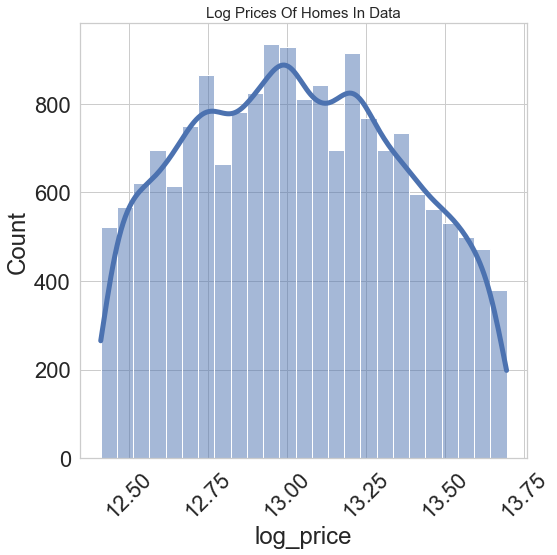

In [326]:
sns.set_style('whitegrid')
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
plt.title('Log Prices Of Homes In Data', fontsize=15)
sns.histplot(x= "log_price",
             data=data_Target_Homes,
             bins=25,
             kde=True,
             line_kws={"linewidth":5}, ax=ax, )
# plt.xticks(ticks=(200000, 400000, 600000, 800000, 900000, 1000000), 
#            labels= ('$200k', '', '', '',
#                     '', '$1mil'))
# plt.xlabel('Price Of Home', fontsize=15)
plt.setp(ax.get_xticklabels(), rotation=45)

plt.show()

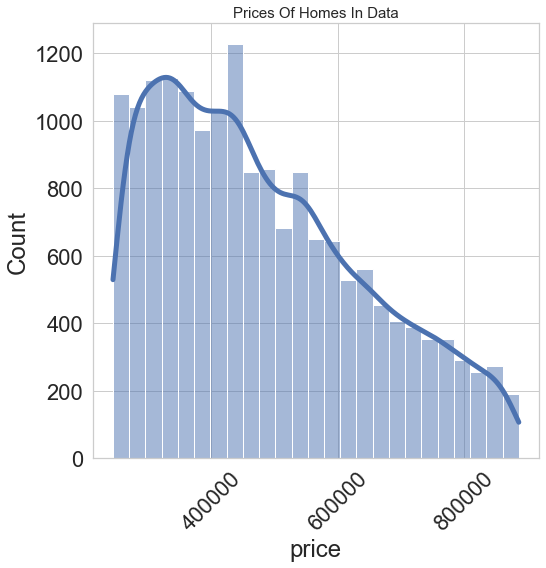

In [327]:
sns.set_style('whitegrid')
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
plt.title('Prices Of Homes In Data', fontsize=15)
sns.histplot(x= "price",
             data=data_Target_Homes,
             bins=25,
             kde=True,
             line_kws={"linewidth":5}, ax=ax, )
# plt.xticks(ticks=(200000, 400000, 600000, 800000, 900000, 1000000), 
#            labels= ('$200k', '', '', '',
#                     '', '$1mil'))
# plt.xlabel('Price Of Home', fontsize=15)
plt.setp(ax.get_xticklabels(), rotation=45)

plt.show()

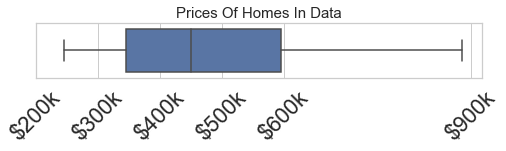

In [328]:
sns.set_style('whitegrid')
fig,ax=plt.subplots(1,1,figsize=(8,1))
plt.title('Prices Of Homes In Data', fontsize=15)
sns.boxplot(x=data_Target_Homes['price'], labels=None)
# sns.boxplot(x=data_No_NAs['price'],ax=ax[1])
# _ , axes = plt.subplots(1, 1, figsize=(15,10))
# sns.boxplot(x=data['bathrooms'],y=data['price'])
plt.xticks(ticks=(200000, 300000, 400000, 500000,600000, 900000), 
           labels= ('$200k','$300k', '$400k', '$500k','$600k','$900k'))
# plt.xlabel('Price Of Home', fontsize=15)
plt.setp(ax.get_xticklabels(), rotation=45)
ax.set_xlabel('')
plt.show();

In [329]:
data_Target_Homes.shape

(17272, 29)

Examin features for outliers

In [330]:
data_Target_Homes.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'If_renovated',
       'AgeOfHome', 'ZipFirst3', 'ZipFirst3_int', 'salesyear', 'sls_month',
       'ttl_rooms', 'log_price'],
      dtype='object')

In [331]:
ColsToCheckForOutliers = data_Target_Homes[['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors','sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15',
       'AgeOfHome','ttl_rooms']]

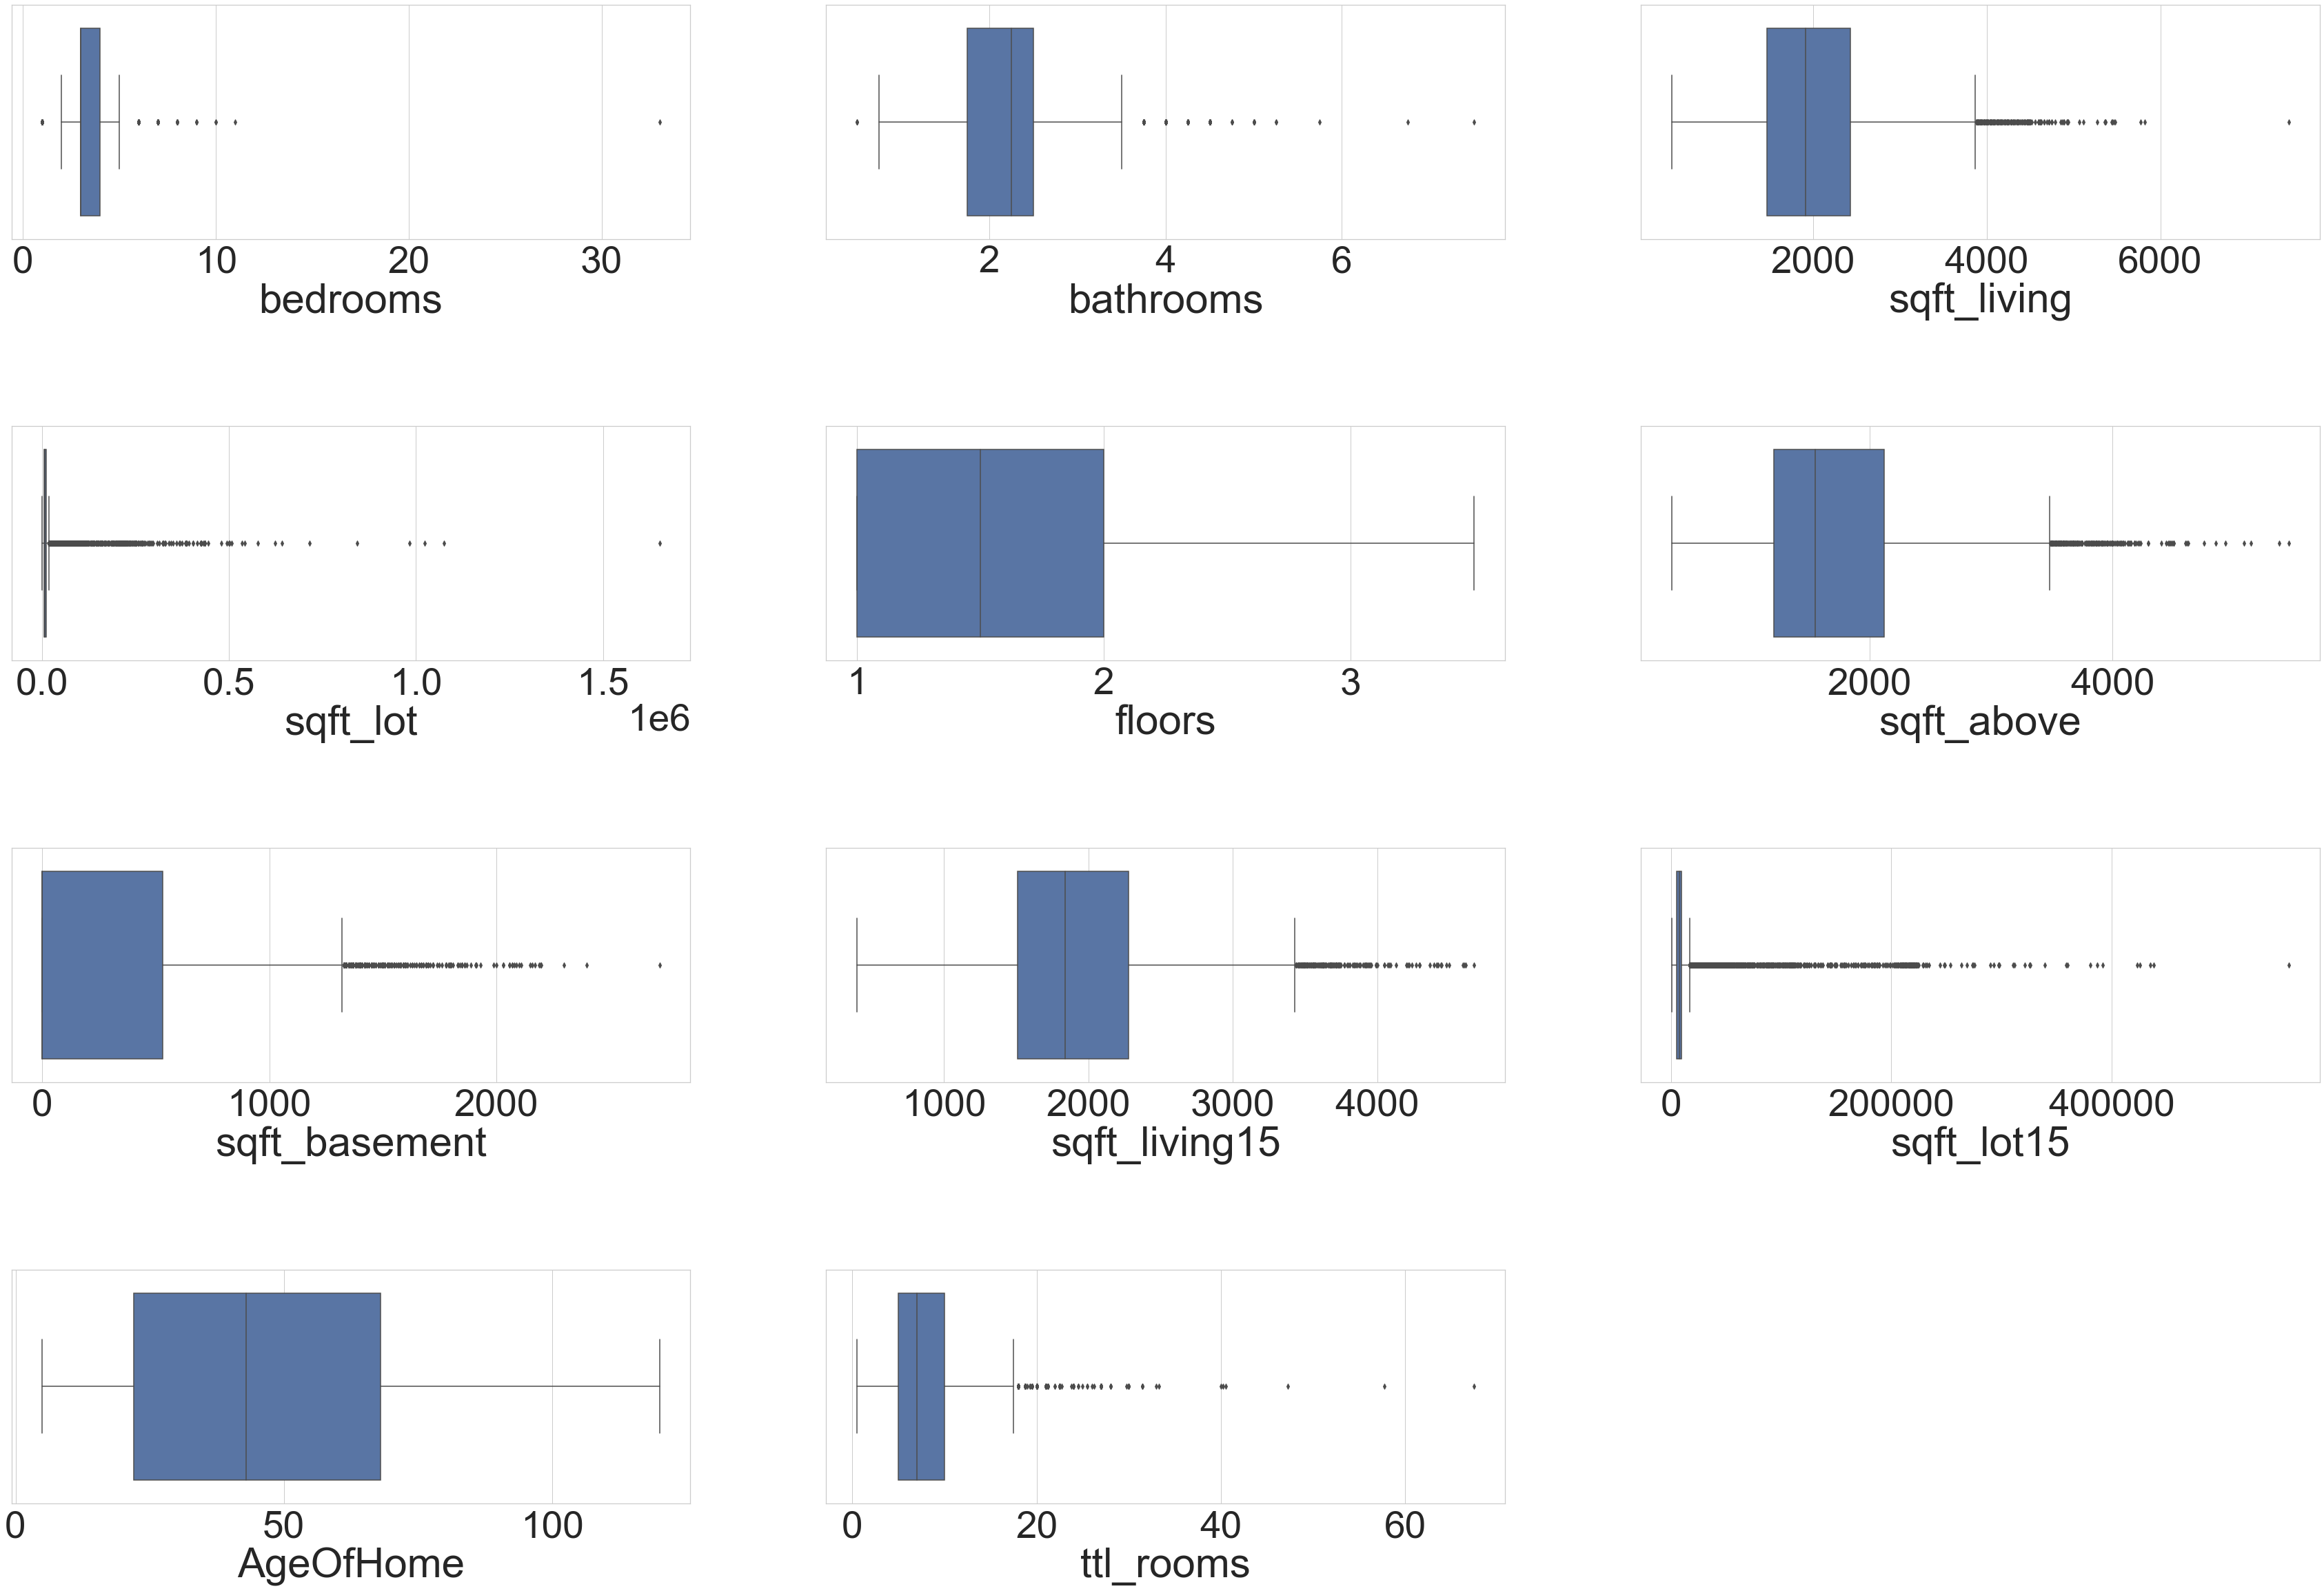

In [332]:
plt.figure(figsize=(60,40), facecolor="white")
plt.subplots_adjust(hspace = 0.8)
sns.set_style('whitegrid')
sns.set(font_scale=5)
sns.set_style("whitegrid")
for index, column in enumerate(ColsToCheckForOutliers):

    if column != "price":
        ax = plt.subplot(4, 3, index+1)
#         sns.boxplot(x=data_Target_Homes['grade'],y=data_Target_Homes['price'],ax=ax[0])
        sns.boxplot(x=column, data=ColsToCheckForOutliers, ax=ax);
         
plt.show();


Remove additional outliers Ex. bedrooms = 33 , Bathrooms < 8, Sqft_Lot <12000. > 4000, Homes that have sold more than 1 on target years

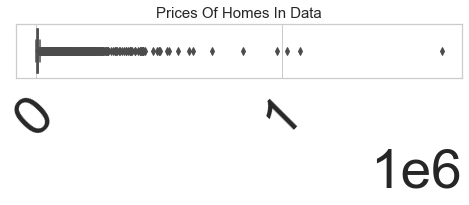

In [333]:
sns.set_style('whitegrid')
fig,ax=plt.subplots(1,1,figsize=(8,1))
plt.title('Prices Of Homes In Data', fontsize=15)
sns.boxplot(x=data_Target_Homes['sqft_lot'], labels=None)
# sns.boxplot(x=data_No_NAs['price'],ax=ax[1])
# _ , axes = plt.subplots(1, 1, figsize=(15,10))
# sns.boxplot(x=data['bathrooms'],y=data['price'])
# plt.xticks(ticks=(200000, 300000, 400000, 500000,600000, 900000), 
#            labels= ('$200k','$300k', '$400k', '$500k','$600k','$900k'))
# plt.xlabel('Price Of Home', fontsize=15)
plt.setp(ax.get_xticklabels(), rotation=45)
ax.set_xlabel('')
plt.show();

In [334]:
#Keep homes that have bewteen 1-6 bathrooms
data_Target_Homes = data_Target_Homes.loc[(1<= data_Target_Homes['bathrooms']) & (data_Target_Homes['bathrooms'] <= 6)]  # > 6 Bathrooms

#Keep homes between 1 - 10 bedrooms < 10
data_Target_Homes = data_Target_Homes.loc[(1<= data_Target_Homes['bedrooms']) & (data_Target_Homes['bedrooms'] <= 10)]  # > 6 Bathrooms

#Keep lots between 4000 and 12000 ft
data_Target_Homes = data_Target_Homes.loc[(4000 <= data_Target_Homes['sqft_lot']) & (data_Target_Homes['sqft_lot'] <= 10000)] #4000, 12000


data_Target_Homes = data_Target_Homes.loc[data_Target_Homes['sqft_above'] >= 700]


# data_Target_Homes = data_Target_Homes.loc[data_Target_Homes['AgeOfHome'] < 50]

# Keep homes with finished basements or are waterfront
data_Target_Homes = data_Target_Homes.loc[(data_Target_Homes['sqft_basement'] >100) | (data_Target_Homes['waterfront']==1)]

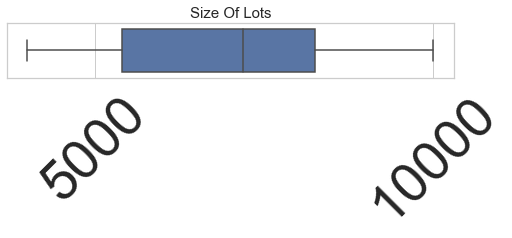

In [335]:
sns.set_style('whitegrid')
fig,ax=plt.subplots(1,1,figsize=(8,1))
plt.title('Size Of Lots', fontsize=15)
sns.boxplot(x=data_Target_Homes['sqft_lot'], labels=None)
# sns.boxplot(x=data_No_NAs['price'],ax=ax[1])
# _ , axes = plt.subplots(1, 1, figsize=(15,10))
# sns.boxplot(x=data['bathrooms'],y=data['price'])
# plt.xticks(ticks=(200000, 300000, 400000, 500000,600000, 900000), 
#            labels= ('$200k','$300k', '$400k', '$500k','$600k','$900k'))
# plt.xlabel('Price Of Home', fontsize=15)
plt.setp(ax.get_xticklabels(), rotation=45)
ax.set_xlabel('')
plt.show();

In [336]:
#Remove Homes That have sold More Than Twice In the Same year (Flipper Homes)
df_housesThatSoldTwice = data_Target_Homes.groupby('id').count().reset_index().sort_values(by="date", ascending=False)
df_housesThatSoldTwice = df_housesThatSoldTwice[df_housesThatSoldTwice["date"] > 1]
data_Target_Homes = data_Target_Homes.merge(df_housesThatSoldTwice[['id','date']], on="id", how='left')
data_Target_Homes.date_y.fillna(0, inplace=True)
data_Target_Homes = data_Target_Homes[data_Target_Homes["date_y"]==0]
data_Target_Homes = data_Target_Homes.drop(['date_y'], axis=1)
data_Target_Homes.rename(columns={"date_x":"date"}, inplace=True)

In [337]:
#Create Pickel of data before transforming dummies
with open('data_Target_Homes.pickle', 'wb') as f:
    pickle.dump(data_Target_Homes, f)

###Review Linearity

In [338]:
CheckForlinearity = data_Target_Homes.drop(columns=['id','date','long', 'ZipFirst3', 'log_price'])

In [339]:
CheckForlinearity.head()

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  zipcode      lat  sqft_living15  sqft_lot15  If_renovated  AgeOfHome  ZipFirst3_int  salesyear  sls_month  ttl_rooms
0  538000.0         3       2.25         2570      7242     2.0         0.0   0.0          3      7        2170          400.0      1951        1991.0    98125  47.7210           1690        7639             1         69            981       2014         12       6.75
1  604000.0         4       3.00         1960      5000     1.0         0.0   0.0          5      7        1050          910.0      1965           0.0    98136  47.5208           1360        5000             0         55            981       2014         12      12.00
2  662500.0         3       2.50         3560      9796     1.0         0.0   0.0          3      8        1860         1700.0      1965           0.0    98007  47.6007           2210        8925             0         55            980       2015          4       7.50
3  468000.0         2       1.00         1160      6000     1.0         0.0   0.0          4      7         860          300.0      1942           0.0    98115  47.6900           1330        6000             0         78            981       2014          5       2.00
4  650000.0         4       3.00         2950      5000     2.0         0.0   3.0          3      9        1980          970.0      1979           0.0    98126  47.5714           2140        4000             0         41            981       2015          1      12.00

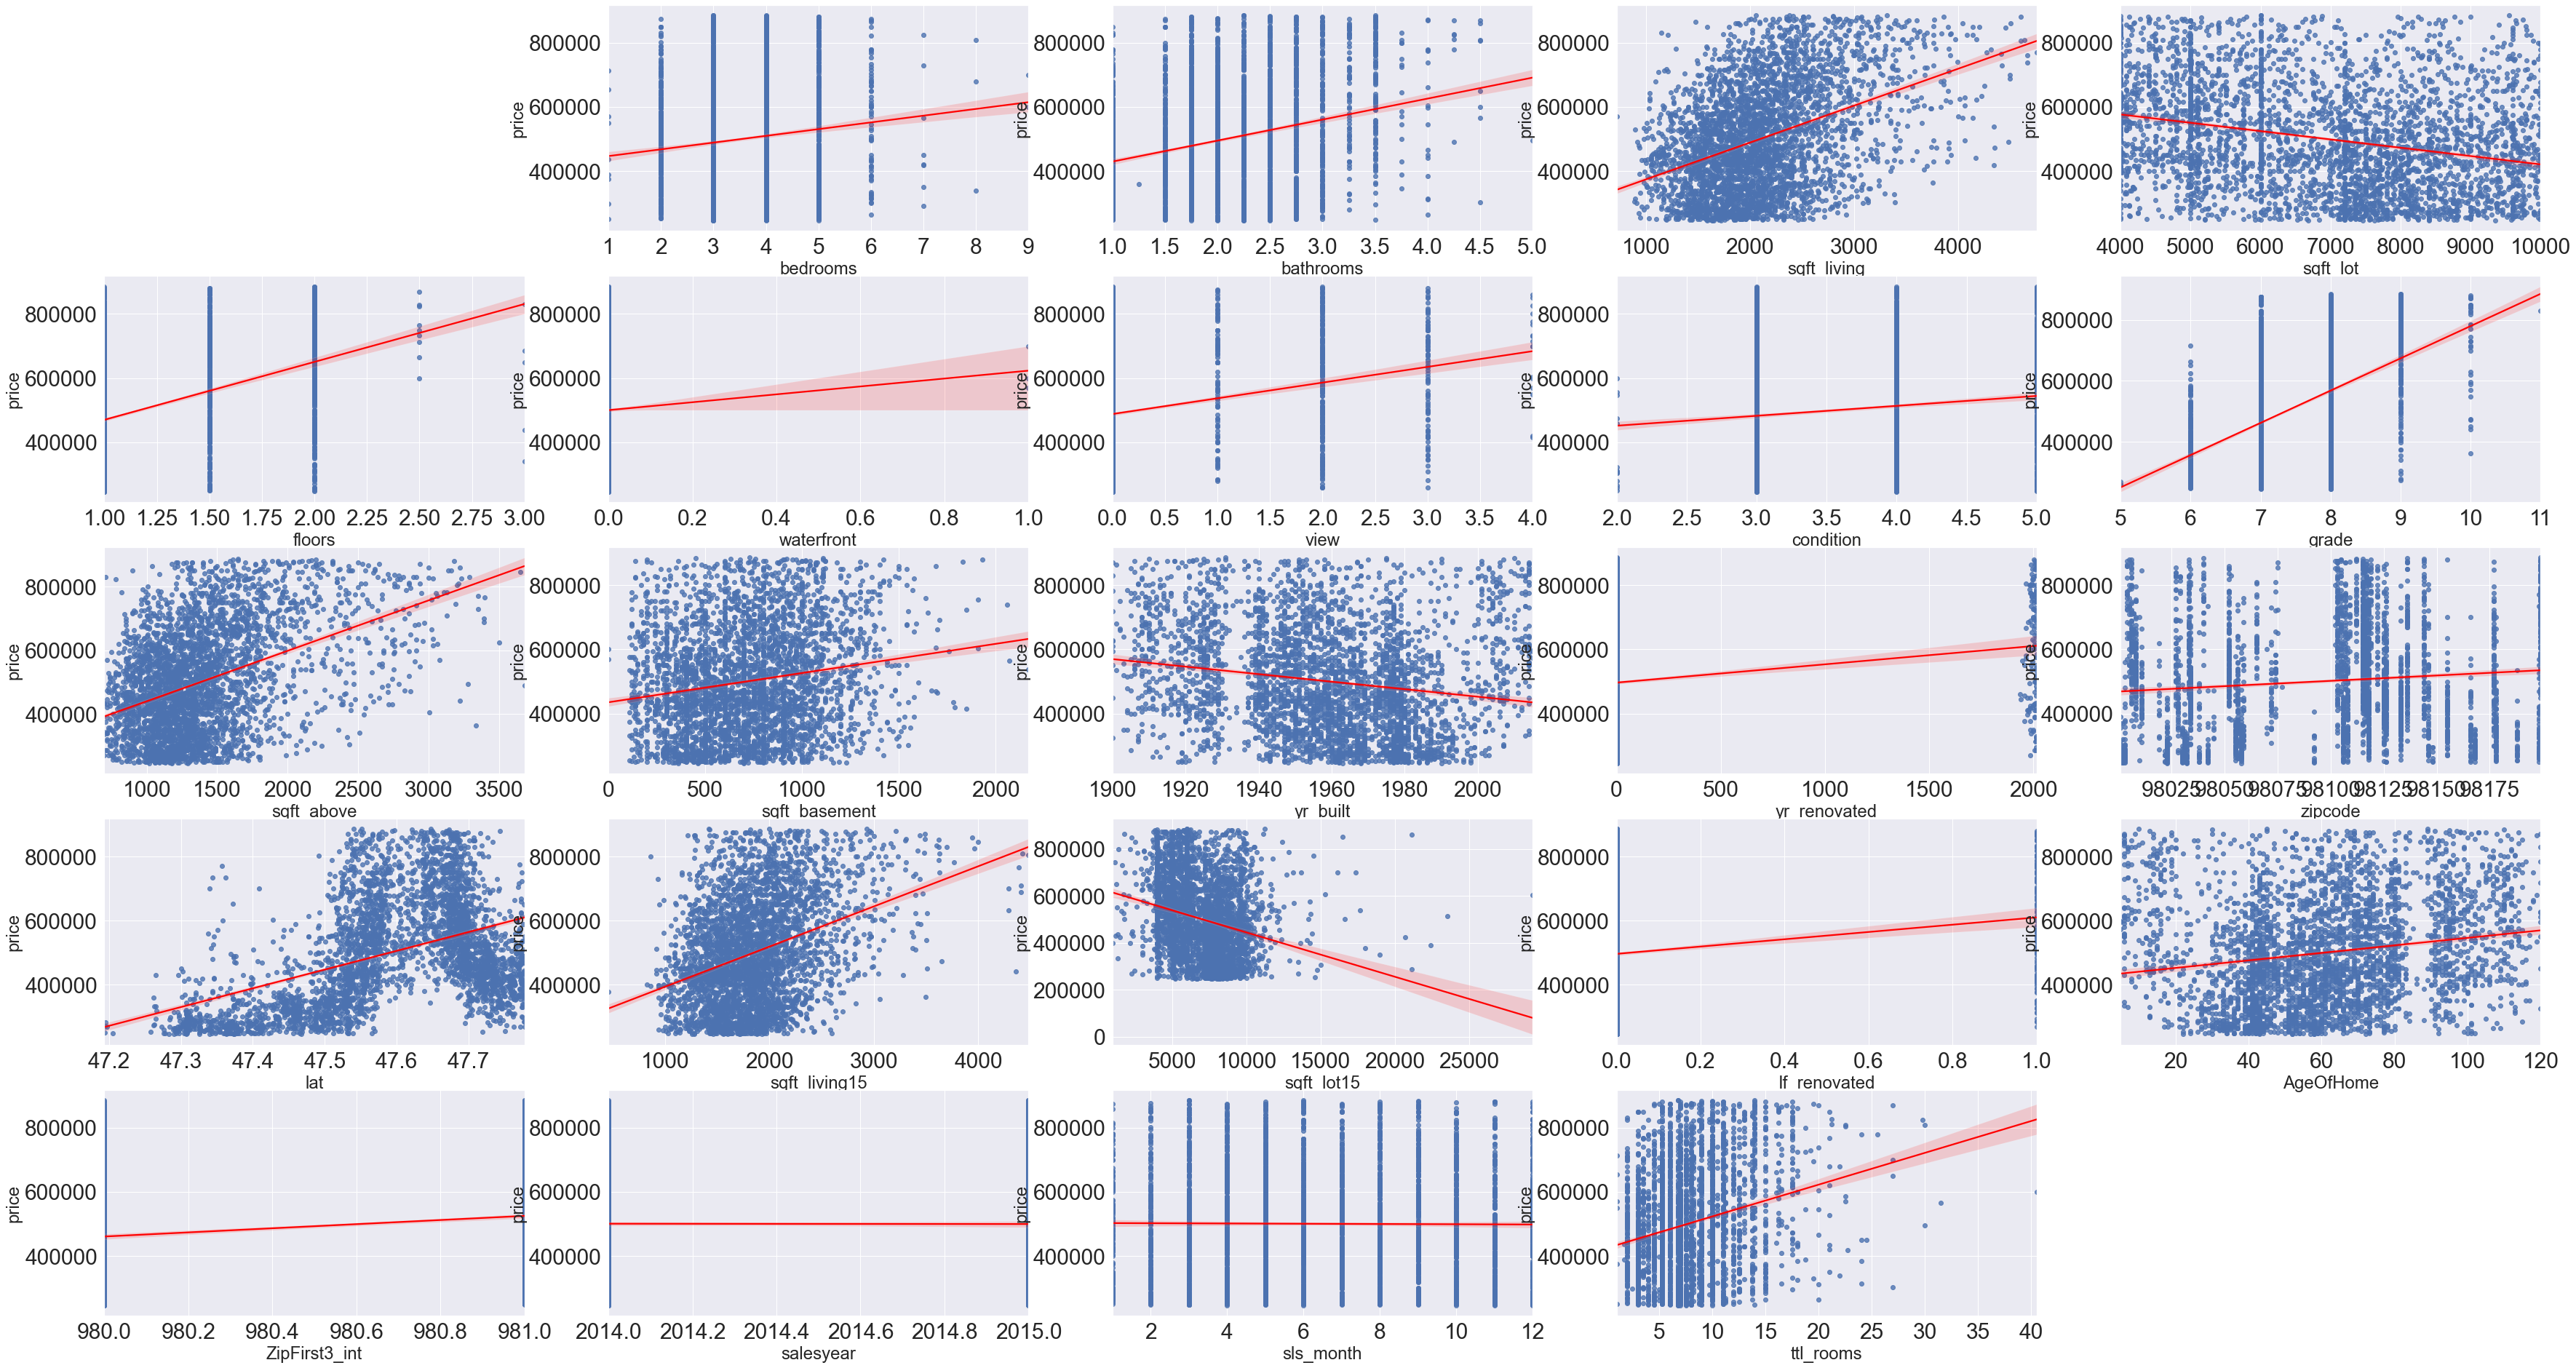

In [340]:
plt.figure(figsize=(60,40), facecolor="white")
sns.set(font_scale=2)

for index, column in enumerate(CheckForlinearity):

    if column != "price":
        ax = plt.subplot(6, 5, index+1)
        sns.regplot(x=column, y="price", data=CheckForlinearity, ax=ax, label='medium', line_kws={"color": "red"});
        plt.ticklabel_format(style='plain', axis='both')
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
    
plt.show();

Get a closer look at a few of the future categoricals

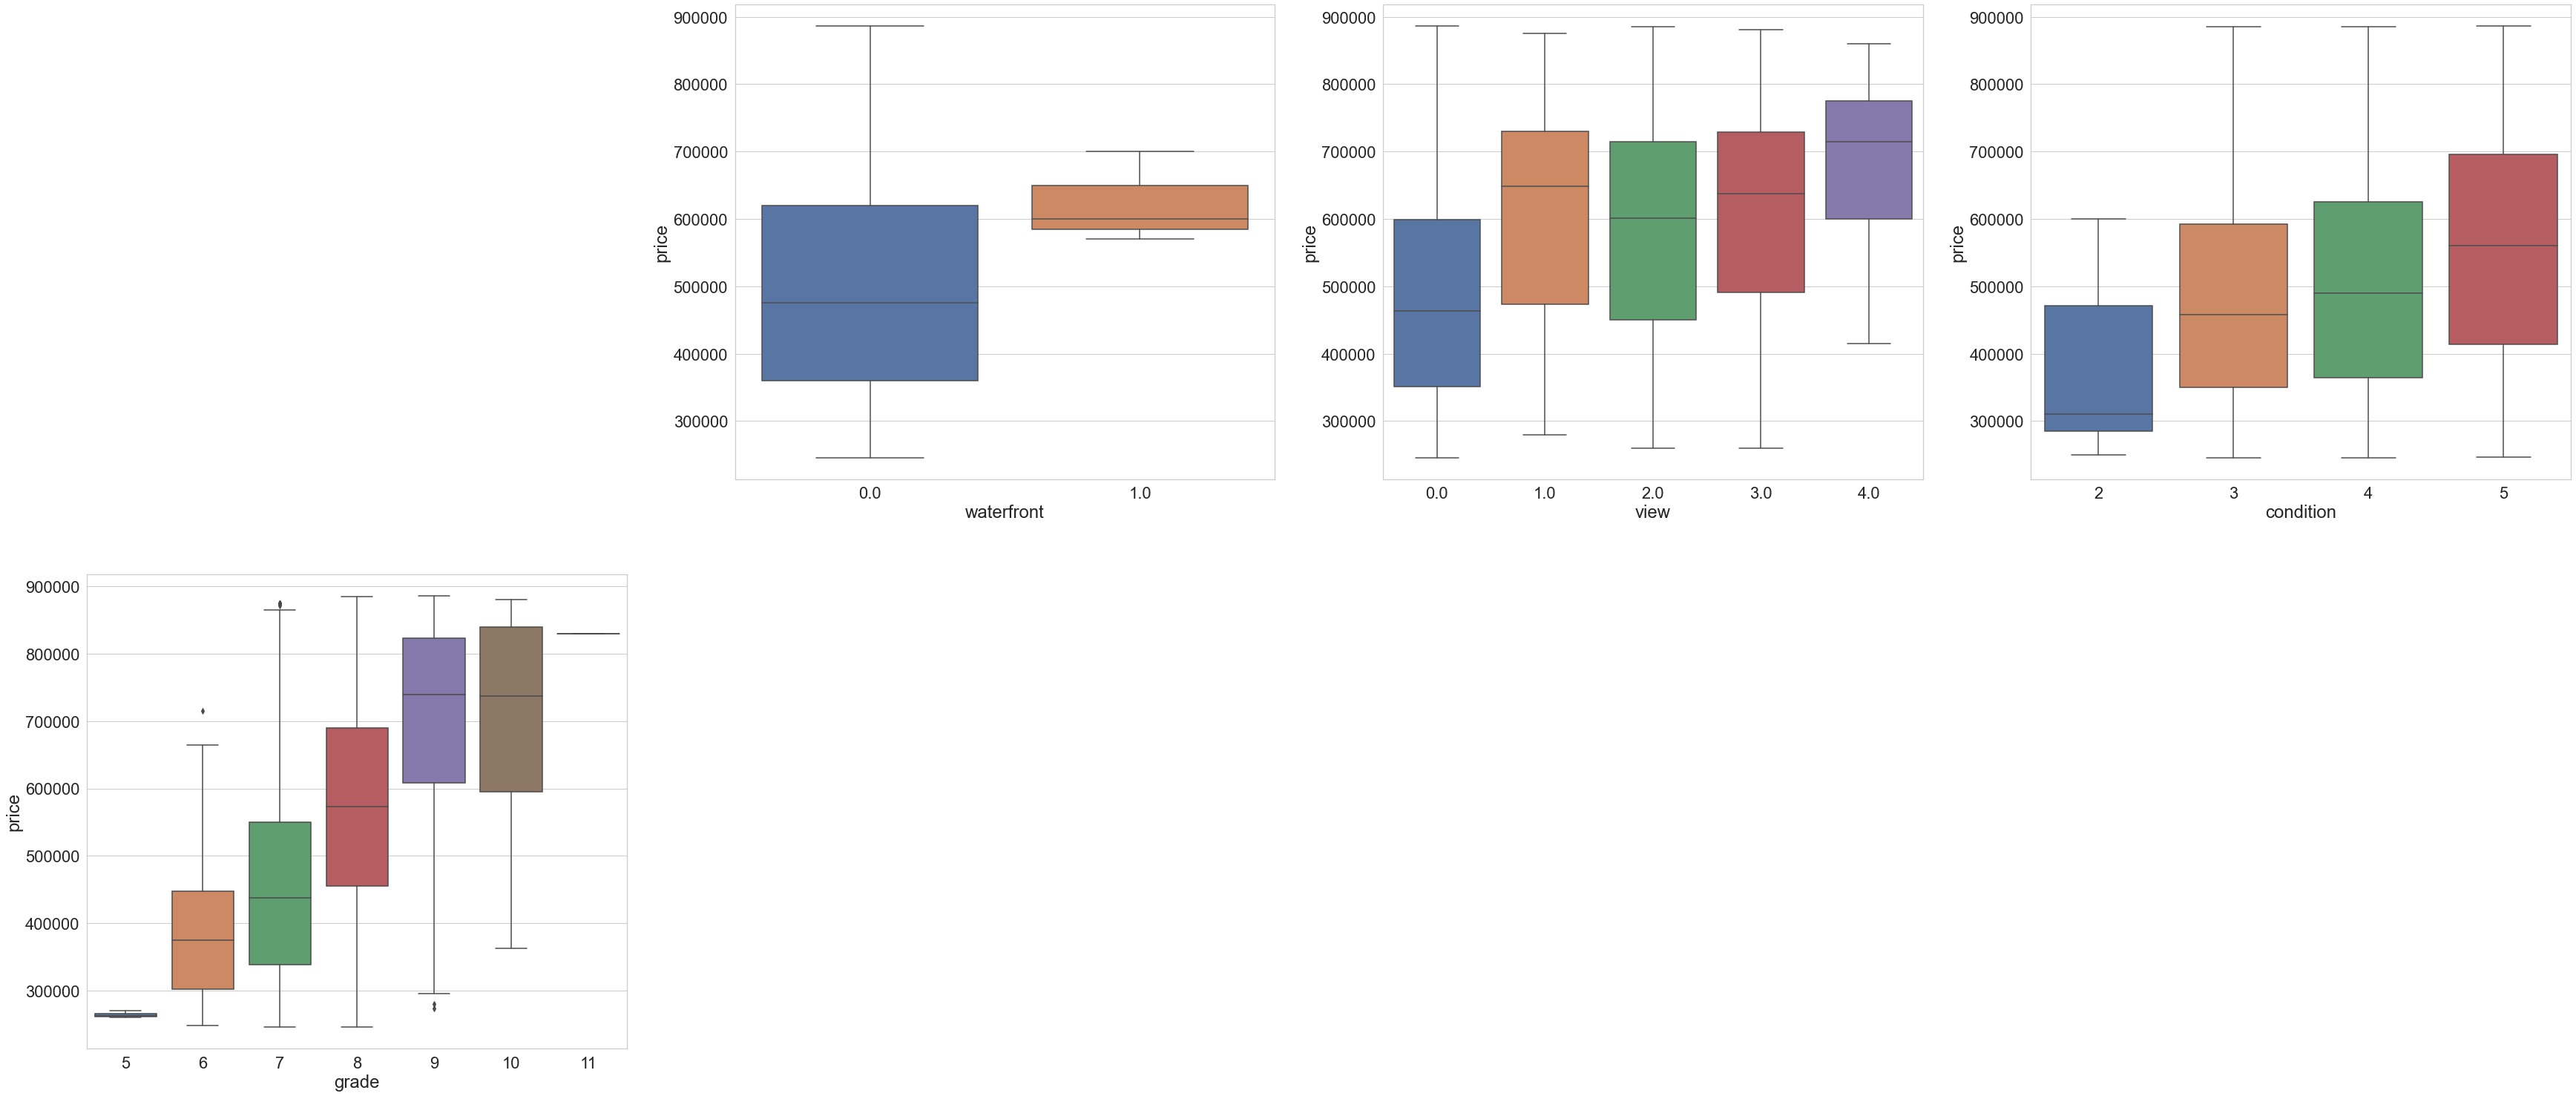

In [341]:

CategoricalsToCheck  = ['price','waterfront', 'view', 'condition', 'grade']


CheckForlinearity1 = CheckForlinearity[CategoricalsToCheck]

plt.figure(figsize=(60,40), facecolor="white")
sns.set(font_scale=2)
sns.set_style("whitegrid")
for index, column in enumerate(CheckForlinearity1):

    if column != "price":
        ax = plt.subplot(3, 4, index+1)
#         sns.boxplot(x=data_Target_Homes['grade'],y=data_Target_Homes['price'],ax=ax[0])
        sns.boxplot(x=column, y="price", data=CheckForlinearity1, ax=ax);
    
plt.show();

Above Confirming linear relationship with categoricals

In [342]:
pd.options.display.float_format = '{:,.0f}'.format
data_Target_Homes.describe()

id   price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  zipcode   lat  long  sqft_living15  sqft_lot15  If_renovated  AgeOfHome  ZipFirst3_int  salesyear  sls_month  ttl_rooms  log_price
count         3,668   3,668     3,668      3,668        3,668     3,668   3,668       3,668 3,668      3,668  3,668       3,668          3,668     3,668         3,668    3,668 3,668 3,668          3,668       3,668         3,668      3,668          3,668      3,668      3,668      3,668      3,668
mean  4,750,326,442 500,402         4          2        2,099     6,932       1           0     0          4      7       1,383            716     1,959            69   98,095    48  -122          1,852       7,027             0         61            981      2,014          7          8         13
std   2,867,154,198 166,025         1          1          594     1,702       0           0     1          1      1         445            317        25           365       55     0     0            459       2,121             0         25              0          0          3          4          0
min       3,600,072 245,700         1          1          720     4,000       1           0     0          2      5         700              0     1,900             0   98,001    47  -122            460         980             0          5            980      2,014          1          1         12
25%   2,323,354,365 360,000         3          2        1,690     5,400       1           0     0          3      7       1,090            480     1,944             0   98,040    48  -122          1,540       5,365             0         43            980      2,014          4          5         13
50%   4,058,801,985 476,700         3          2        2,020     7,180       1           0     0          3      7       1,290            700     1,960             0   98,115    48  -122          1,800       7,210             0         60            981      2,014          6          7         13
75%   7,467,400,165 620,000         4          2        2,400     8,255       1           0     0          4      8       1,550            920     1,977             0   98,126    48  -122          2,080       8,349             0         76            981      2,015          9         10         13
max   9,900,000,190 886,000         9          5        4,750    10,000       3           1     4          5     11       3,680          2,170     2,015         2,015   98,199    48  -122          4,480      29,279             1        120            981      2,015         12         40         14

50% Data Points Between $800,000 - and $250,000, Remove Outliers on both sides and rerun, currently mean and standard deviation impacted significantly by large home values

In [343]:
# df_check2 = data_Target_Homes.loc[data_Target_Homes.waterfront ==1]
# df_check2

##    B. Scaling, Converting & Eliminating Multicolinearity

In [344]:
data_Target_Homes.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'If_renovated',
       'AgeOfHome', 'ZipFirst3', 'ZipFirst3_int', 'salesyear', 'sls_month',
       'ttl_rooms', 'log_price'],
      dtype='object')

In [345]:
# #Exclude metadatacolumns from colinearity check as they will not feed into regression model directely
# ColsToDrop = ["id","date", "log_price", "zipcode", "long", "lat", "ZipFirst3", "ZipFirst3_int","yr_built","price"]
# CheckForlinearity2 = data_No_NAs.drop(columns=ColsToDrop)

model1_Continuous_variables  = ['bedrooms', 'bathrooms','sqft_living','sqft_lot',
                                'sqft_basement','sqft_living15', 'sqft_lot15', 'floors',
                                'sqft_above','AgeOfHome','ttl_rooms']

data_Target_Homes_Continuous = data_Target_Homes[model1_Continuous_variables]
# model1_Continuous_variables = data_Target_Homes_Continuous.columns

In [346]:
#Scale Continuous initial data
scaled_df_no_index, scaler_1 = scaleData_min_max (data_Target_Homes_Continuous)

In [347]:
# pd.reset_option('display.float_format')
# scaled_df_no_index.head()

In [348]:
# # df = pd.DataFrame([[1,1.23,'Hello']], columns=list('ABC'))
# df2 = pd.DataFrame([[4000]],columns=['sqft_lot'])
# type(df2)

In [349]:
# value = scaler_1.transform(df2)
# value

Convert Categorical To Dummy

In [350]:
data_Target_Homes.grade.value_counts()

7     2142
8     1062
6      231
9      197
10      32
5        3
11       1
Name: grade, dtype: int64

In [351]:
# categoricals = ['waterfront', 'view', 'condition', 'grade']
# dummies = pd.get_dummies(data_with_Ap_Hot_Dist_POints[categoricals], prefix=categoricals, drop_first=True)

dummies_3digitZip = pd.get_dummies(data_Target_Homes['ZipFirst3'], prefix='ZipFirst3', drop_first=True)
data_Target_Homes = data_Target_Homes.drop('ZipFirst3', axis=1)

dummies_water = pd.get_dummies(data_Target_Homes['waterfront'], prefix='waterfront', drop_first=True)
data_Target_Homes = data_Target_Homes.drop('waterfront', axis=1)

dummies_view = pd.get_dummies(data_Target_Homes['view'], prefix='view', drop_first=True)
data_Target_Homes = data_Target_Homes.drop('view', axis=1)

dummies_condition = pd.get_dummies(data_Target_Homes['condition'], prefix='condition', drop_first=True)
data_Target_Homes = data_Target_Homes.drop('condition', axis=1)

dummies_grade = pd.get_dummies(data_Target_Homes['grade'], prefix='grade', drop_first=True)
data_Target_Homes = data_Target_Homes.drop('grade', axis=1)

dummies_salesMnth = pd.get_dummies(data_Target_Homes['sls_month'], prefix='sls_mnth' ,drop_first=True)
data_Target_Homes = data_Target_Homes.drop('sls_month', axis=1)

dummies_ifRenovated = pd.get_dummies(data_Target_Homes['If_renovated'], prefix='If_renovated' ,drop_first=True)
data_Target_Homes = data_Target_Homes.drop('If_renovated', axis=1)

data_Target_Homes_Not_Scaled_WithDummies = pd.concat([data_Target_Homes, dummies_water], axis=1)
data_Target_Homes_Not_Scaled_WithDummies = pd.concat([data_Target_Homes_Not_Scaled_WithDummies, dummies_3digitZip], axis=1)
data_Target_Homes_Not_Scaled_WithDummies = pd.concat([data_Target_Homes_Not_Scaled_WithDummies, dummies_view], axis=1)
data_Target_Homes_Not_Scaled_WithDummies = pd.concat([data_Target_Homes_Not_Scaled_WithDummies, dummies_condition], axis=1)
data_Target_Homes_Not_Scaled_WithDummies = pd.concat([data_Target_Homes_Not_Scaled_WithDummies, dummies_grade], axis=1)
data_Target_Homes_Not_Scaled_WithDummies = pd.concat([data_Target_Homes_Not_Scaled_WithDummies, dummies_salesMnth], axis=1)
data_Target_Homes_Not_Scaled_WithDummies = pd.concat([data_Target_Homes_Not_Scaled_WithDummies, dummies_ifRenovated], axis=1)

data_Target_Homes_Not_Scaled_WithDummies.rename(columns={'waterfront_1.0': 'waterfront_1', 'view_1.0': 'view_1',
                'view_1.0':'view_1', 'view_2.0':'view_2', 'view_3.0':'view_3', 'view_4.0':'view_4'}, inplace=True)

data_Target_Homes_Scaled_WithDummies = data_Target_Homes_Not_Scaled_WithDummies.drop(['bedrooms', 'bathrooms',
                                                                                      'sqft_living',
                                                                                      'sqft_lot', 'floors', 
                                                                                      'sqft_above', 
                                                                                      'sqft_basement',
                                                                                      'sqft_living15', 
                                                                                      'sqft_lot15',
                                                                                      'AgeOfHome',
                                                                                     'ttl_rooms'],
                                                                                     axis = 1)

data_Target_Homes_Scaled_WithDummies = data_Target_Homes_Scaled_WithDummies.reset_index(drop=True)
data_Target_Homes_Scaled_WithDummies = pd.concat([data_Target_Homes_Scaled_WithDummies, scaled_df_no_index], axis=1)

In [352]:
data_Target_Homes_Scaled_WithDummies.head()

id       date   price  yr_built  yr_renovated  zipcode  lat  long  ZipFirst3_int  salesyear  log_price  waterfront_1  ZipFirst3_981  view_1  view_2  view_3  view_4  condition_3  condition_4  condition_5  grade_6  grade_7  grade_8  grade_9  grade_10  grade_11  sls_mnth_2  sls_mnth_3  sls_mnth_4  sls_mnth_5  sls_mnth_6  sls_mnth_7  sls_mnth_8  sls_mnth_9  sls_mnth_10  sls_mnth_11  sls_mnth_12  If_renovated_1  bedrooms  bathrooms  sqft_living  sqft_lot  sqft_basement  sqft_living15  sqft_lot15  floors  sqft_above  AgeOfHome  ttl_rooms
0  6414100192  12/9/2014 538,000      1951         1,991    98125   48  -122            981       2014         13             0              1       0       0       0       0            1            0            0        0        1        0        0         0         0           0           0           0           0           0           0           0           0            0            0            1               1         0          0            0         1              0              0           0       0           0          1          0
1  2487200875  12/9/2014 604,000      1965             0    98136   48  -122            981       2014         13             0              1       0       0       0       0            0            0            1        0        1        0        0         0         0           0           0           0           0           0           0           0           0            0            0            1               0         0          0            0         0              0              0           0       0           0          0          0
2  1736800520   4/3/2015 662,500      1965             0    98007   48  -122            980       2015         13             0              0       0       0       0       0            1            0            0        0        0        1        0         0         0           0           0           1           0           0           0           0           0            0            0            0               0         0          0            1         1              1              0           0       0           0          0          0
3  9212900260  5/27/2014 468,000      1942             0    98115   48  -122            981       2014         13             0              1       0       0       0       0            0            1            0        0        1        0        0         0         0           0           0           0           1           0           0           0           0            0            0            0               0         0          0            0         0              0              0           0       0           0          1          0
4  9297300055  1/24/2015 650,000      1979             0    98126   48  -122            981       2015         13             0              1       0       0       1       0            1            0            0        0        0        0        1         0         0           0           0           0           0           0           0           0           0            0            0            0               0         0          0            1         0              0              0           0       0           0          0          0

In [353]:
pd.reset_option('display.float_format')
data_Target_Homes_Scaled_WithDummies.describe()
# data_Target_Homes_Scaled_WithDummies.head()

id          price     yr_built  yr_renovated       zipcode          lat         long  ZipFirst3_int    salesyear    log_price  waterfront_1  ZipFirst3_981       view_1       view_2       view_3       view_4  condition_3  condition_4  condition_5      grade_6      grade_7      grade_8      grade_9     grade_10     grade_11   sls_mnth_2   sls_mnth_3   sls_mnth_4   sls_mnth_5   sls_mnth_6   sls_mnth_7   sls_mnth_8   sls_mnth_9  sls_mnth_10  sls_mnth_11  sls_mnth_12  If_renovated_1     bedrooms    bathrooms  sqft_living     sqft_lot  sqft_basement  sqft_living15   sqft_lot15       floors   sqft_above    AgeOfHome    ttl_rooms
count  3.668000e+03    3668.000000  3668.000000   3668.000000   3668.000000  3668.000000  3668.000000    3668.000000  3668.000000  3668.000000   3668.000000    3668.000000  3668.000000  3668.000000  3668.000000  3668.000000  3668.000000  3668.000000  3668.000000  3668.000000  3668.000000  3668.000000  3668.000000  3668.000000  3668.000000  3668.000000  3668.000000  3668.000000  3668.000000  3668.000000  3668.000000  3668.000000  3668.000000  3668.000000  3668.000000  3668.000000     3668.000000  3668.000000  3668.000000  3668.000000  3668.000000    3668.000000    3668.000000  3668.000000  3668.000000  3668.000000  3668.000000  3668.000000
mean   4.750326e+09  500401.983097  1959.134133     69.153762  98095.331516    47.590555  -122.272616     980.615867  2014.315976    13.066909      0.000818       0.615867     0.026990     0.063250     0.025627     0.004635     0.536260     0.342421     0.117503     0.062977     0.583969     0.289531     0.053708     0.008724     0.000273     0.057525     0.085060     0.104417     0.116140     0.103326     0.094057     0.092694     0.083152     0.086696     0.063522     0.074973        0.034624     0.319418     0.270515     0.342204     0.488733       0.330107       0.346178     0.213695     0.083765     0.229110     0.485790     0.169354
std    2.867154e+09  166025.269337    24.933935    365.219155     54.752797     0.122876     0.104404       0.486456     0.464967     0.339046      0.028591       0.486456     0.162077     0.243445     0.158041     0.067930     0.498752     0.474584     0.322062     0.242955     0.492966     0.453607     0.225471     0.093007     0.016511     0.232874     0.279009     0.305842     0.320436     0.304426     0.291947     0.290042     0.276149     0.281427     0.243933     0.263383        0.182850     0.112490     0.164007     0.147320     0.283748       0.146295       0.114115     0.074945     0.173552     0.149394     0.216817     0.097308
min    3.600072e+06  245700.000000  1900.000000      0.000000  98001.000000    47.193700  -122.456000     980.000000  2014.000000    12.411867      0.000000       0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000        0.000000     0.000000     0.000000     0.000000     0.000000       0.000000       0.000000     0.000000     0.000000     0.000000     0.000000     0.000000
25%    2.323354e+09  360000.000000  1944.000000      0.000000  98040.000000    47.521125  -122.357000     980.000000  2014.000000    12.793859      0.000000       0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000        0.000000     0.250000     0.187500     0.240695     0.233333       0.221198       0.268657     0.154952     0.000000     0.130872     0.330435     0.107595
50%    4.058802e+09  476700.000000  1960.000000      0.000000  98115.000000    47.597250  -122.296000     981.000000  2014.000000    13

In [354]:
model1_Categorical_variables = ['waterfront_1', 'view_1', 
                                'view_2', 'view_3', 'view_4', 
                                'condition_3','condition_4', 'condition_5','grade_6',
                                'grade_7','grade_8', 'grade_9', 'grade_10','grade_11', 'ZipFirst3_981',
                               "sls_mnth_2","sls_mnth_3","sls_mnth_4","sls_mnth_5","sls_mnth_6","sls_mnth_7",
                               "sls_mnth_8","sls_mnth_9", "sls_mnth_10","sls_mnth_11","sls_mnth_12","If_renovated_1"]

Next Find Correlation and Mulicolinearity

In [355]:
model1_Categorical_variables_to_remove = ['Na']

# model1_Categorical_variables_to_remove = ['grade_5','grade_6','condition_3', 'condition_2', 'grade_11']
model1_Categorical_variables = [e for e in model1_Categorical_variables if e not in (model1_Categorical_variables_to_remove)]

model1_Continuous_variables_to_remove = ['na']
model1_Continuous_variables = [e for e in model1_Continuous_variables if e not in (model1_Continuous_variables_to_remove)]

colstoCheck = model1_Categorical_variables + model1_Continuous_variables

data_Review_Colinearity_Model1 = data_Target_Homes_Scaled_WithDummies[colstoCheck]
df_fromCheck = checkForColinearity (data_Review_Colinearity_Model1)
df_fromCheck

cc
pairs                               
(bathrooms, ttl_rooms)      0.877540
(sqft_living, sqft_above)   0.851069
(ttl_rooms, bedrooms)       0.811642
(condition_3, condition_4)  0.775990
(sqft_lot, sqft_lot15)      0.759141
(grade_7, grade_8)          0.756323

Remove Columns with > .70 correlation

In [356]:
model1_Categorical_variables_to_remove = ['grade_7','condition_3']
model1_Categorical_variables = [e for e in model1_Categorical_variables if e not in (model1_Categorical_variables_to_remove)]


model1_Continuous_variables_to_remove = ['bathrooms', "bedrooms", "sqft_lot15", "sqft_living",  'floors']
model1_Continuous_variables = [e for e in model1_Continuous_variables if e not in (model1_Continuous_variables_to_remove)]


#Create Dataframefor Correlation check
colstoCheck = model1_Categorical_variables + model1_Continuous_variables

data_Review_Colinearity_Model1 = data_Target_Homes_Scaled_WithDummies[colstoCheck]
df_fromCheck = checkForColinearity (data_Review_Colinearity_Model1)
df_fromCheck

Empty DataFrame
Columns: [cc]
Index: []

In [357]:
vifResults = checkForVIF(data_Review_Colinearity_Model1)
vifResults

[('waterfront_1', 1.2234795165840127),
 ('view_1', 1.058851512140844),
 ('view_2', 1.1331114356460683),
 ('view_3', 1.078482103911224),
 ('view_4', 1.2414089282250547),
 ('condition_4', 1.8689660127516068),
 ('condition_5', 1.4167113336218848),
 ('grade_6', 1.1928849029797637),
 ('grade_8', 2.0137836709259602),
 ('grade_9', 1.7050182728500594),
 ('grade_10', 1.1991959937360894),
 ('grade_11', 1.0157220769393216),
 ('ZipFirst3_981', 4.462344315338232),
 ('sls_mnth_2', 1.8964159356623138),
 ('sls_mnth_3', 2.322353332674346),
 ('sls_mnth_4', 2.6316800839204397),
 ('sls_mnth_5', 2.8048025673364783),
 ('sls_mnth_6', 2.6431437141202503),
 ('sls_mnth_7', 2.495473066661459),
 ('sls_mnth_8', 2.4771777618947546),
 ('sls_mnth_9', 2.3292819240177214),
 ('sls_mnth_10', 2.4069916073408097),
 ('sls_mnth_11', 1.9870415314511167),
 ('sls_mnth_12', 2.1678986392588224),
 ('If_renovated_1', 1.16734537504166),
 ('sqft_lot', 4.933793236536014),
 ('sqft_basement', 8.256702436907018),
 ('sqft_living15', 17.20

Remove features with VIF > 10 from model 

In [358]:
model1_Categorical_variables_to_remove = ['NA']
model1_Categorical_variables = [e for e in model1_Categorical_variables if e not in (model1_Categorical_variables_to_remove)]


model1_Continuous_variables_to_remove = ['sqft_living15', 'AgeOfHome', 'ttl_rooms']
model1_Continuous_variables = [e for e in model1_Continuous_variables if e not in (model1_Continuous_variables_to_remove)]


#Create Dataframefor Correlation check
colstoCheck = model1_Categorical_variables + model1_Continuous_variables

data_Review_Colinearity_Model1 = data_Target_Homes_Scaled_WithDummies[colstoCheck]

In [359]:
vifResults = checkForVIF(data_Review_Colinearity_Model1)
vifResults

[('waterfront_1', 1.2230283805568885),
 ('view_1', 1.0504864303912318),
 ('view_2', 1.1232012791152588),
 ('view_3', 1.0699002972707876),
 ('view_4', 1.239416028704361),
 ('condition_4', 1.6884364306542718),
 ('condition_5', 1.2966605585112048),
 ('grade_6', 1.1547969346586335),
 ('grade_8', 1.8911467203892407),
 ('grade_9', 1.5628675731577102),
 ('grade_10', 1.1613391522905012),
 ('grade_11', 1.0146245030248406),
 ('ZipFirst3_981', 3.1932146654052915),
 ('sls_mnth_2', 1.5954365560076307),
 ('sls_mnth_3', 1.880863572864325),
 ('sls_mnth_4', 2.0852193679804185),
 ('sls_mnth_5', 2.185734575337474),
 ('sls_mnth_6', 2.125033653097364),
 ('sls_mnth_7', 2.0415432906530113),
 ('sls_mnth_8', 2.013490143629826),
 ('sls_mnth_9', 1.888397736020387),
 ('sls_mnth_10', 1.9578836777744955),
 ('sls_mnth_11', 1.6405576353744946),
 ('sls_mnth_12', 1.813658409520663),
 ('If_renovated_1', 1.0761170306138148),
 ('sqft_lot', 4.606892717565416),
 ('sqft_basement', 6.501086487555035),
 ('sqft_above', 5.557610

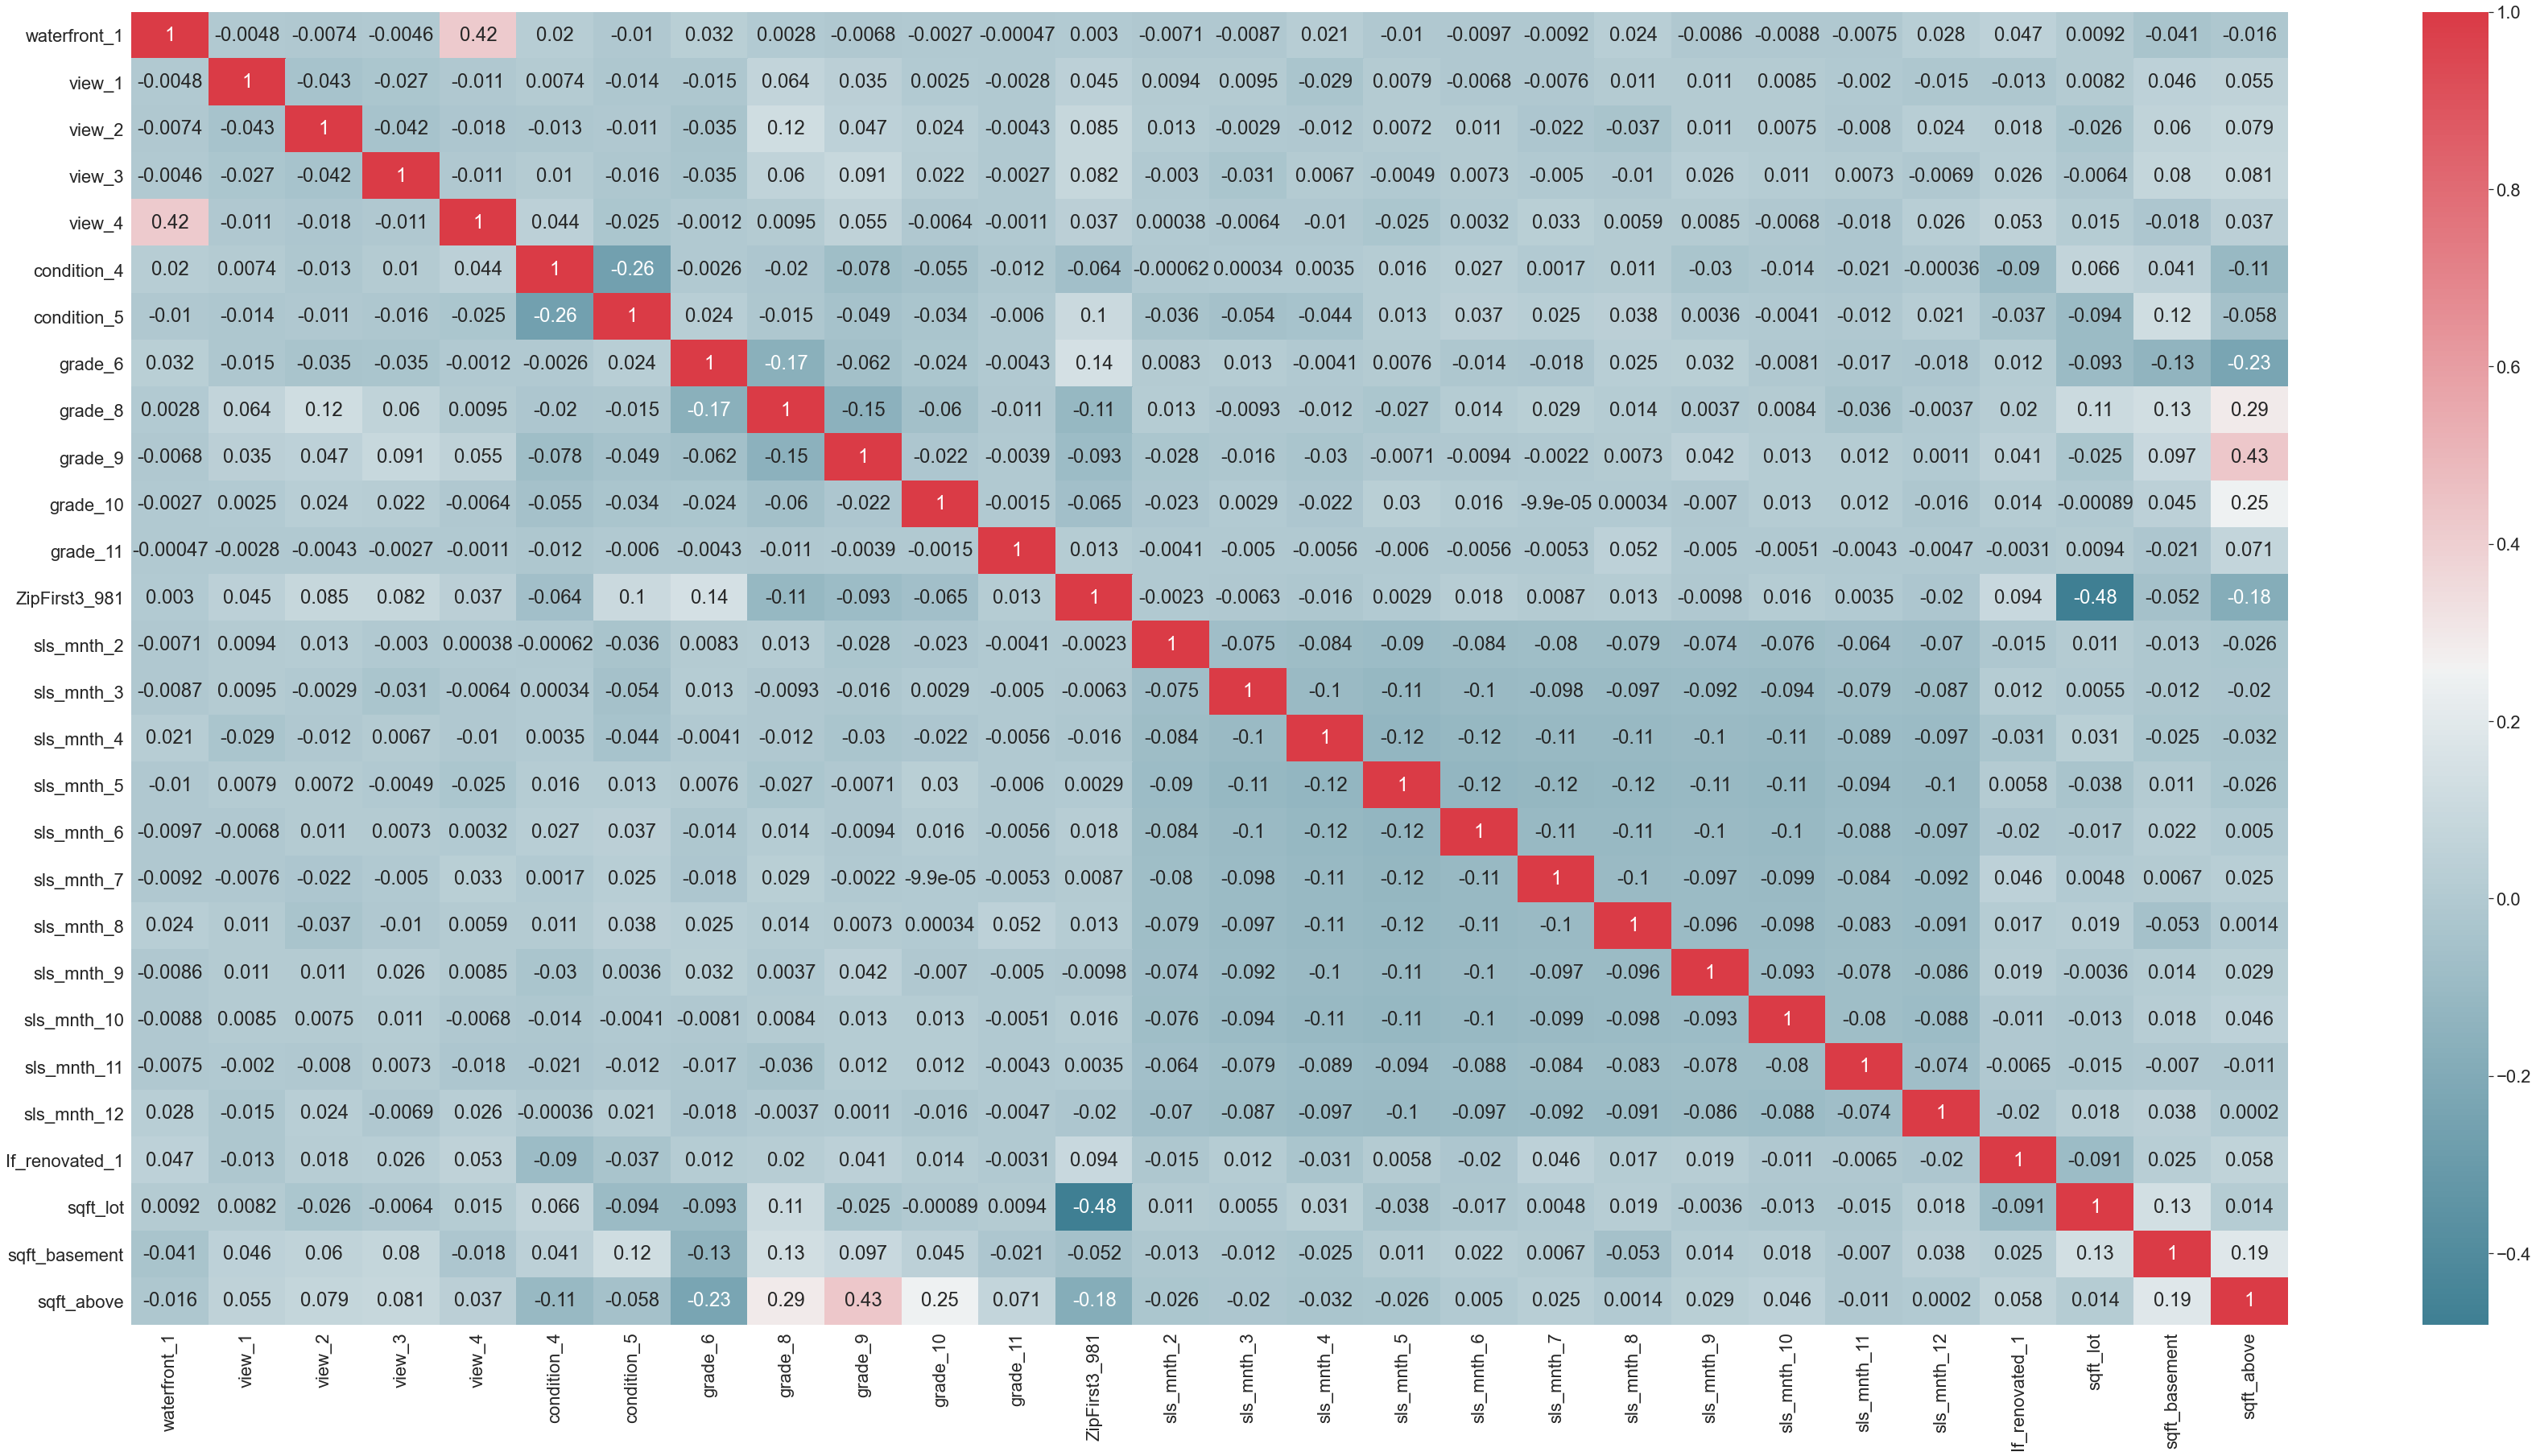

In [360]:
correlation_heatmap(data_Review_Colinearity_Model1)


# plt.figure(figsize=(12,12))
# # Compute the correlation matrix
# corr = df.corr()

# # Generate a mask for the upper triangle
# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True
# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, center=0, vmin=0.5, square=True, linewidths=.5, cmap='ocean')
# plt.title('Correlation between features', fontdict={'fontsize': 16})
# plt.show()

In [361]:
#Remove Columns from our list of continuous and Categorical values indentified in VIF and Colinear testing

# model1_Categorical_variables_to_remove = ['NA']
# model1_Categorical_variables = [e for e in model1_Categorical_variables if e not in (model1_Categorical_variables_to_remove)]


# model1_Continuous_variables_to_remove = ['sqft_above','sqft_living15','bathrooms','bedrooms']
# model1_Continuous_variables = [e for e in model1_Continuous_variables if e not in (model1_Continuous_variables_to_remove)]

# #Add newly created features to model
# data_Target_Homes_Scaled_WithDummies["ttl_Rooms"] = data_Review_Colinearity_Model1["ttl_Rooms"]
# model1_Continuous_variables.append("ttl_Rooms")
# data_Target_Homes_Scaled_WithDummies["sqft_Above_Combo"] = data_Review_Colinearity_Model1["sqft_Above_Combo"]
# model1_Continuous_variables.append("sqft_Above_Combo")

##    C. Create Pickle of Dataset

Get All needed fields ready for Pickle file

In [362]:
FieldsMovingForward = ['id','date', 'price', 'yr_built', 'yr_renovated', 'zipcode', 'lat',
       'long', 'log_price']

FieldsMovingForward.extend(data_Review_Colinearity_Model1.columns)
data_Target_Homes_Scaled_WithDummies = data_Target_Homes_Scaled_WithDummies[FieldsMovingForward]

Create Pickle File for testing Initial Model

In [363]:
with open('regression_Data_Initial_Model.pickle', 'wb') as f:
    pickle.dump(data_Target_Homes_Scaled_WithDummies, f)
    
with open('regression_Data_xref.pickle', 'wb') as f:
    pickle.dump(data_Target_Homes_Not_Scaled_WithDummies, f)

In [364]:
#Create Pickle of minmaxScaler
with open('scaler_1.pickle', 'wb') as f:
    pickle.dump(scaler_1, f)

with open('data_Target_Homes_Not_Scaled_WithDummies.pickle', 'wb') as f:
    pickle.dump(data_Target_Homes_Not_Scaled_WithDummies, f)

with open('model1_Continuous_variables.pickle', 'wb') as f:
    pickle.dump(model1_Continuous_variables, f)

In [365]:
data_Target_Homes_Not_Scaled_WithDummies.head()

id       date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  sqft_above  sqft_basement  yr_built  yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  AgeOfHome  ZipFirst3_int  salesyear  ttl_rooms  log_price  waterfront_1  ZipFirst3_981  view_1  view_2  view_3  view_4  condition_3  condition_4  condition_5  grade_6  grade_7  grade_8  grade_9  grade_10  grade_11  sls_mnth_2  sls_mnth_3  sls_mnth_4  sls_mnth_5  sls_mnth_6  sls_mnth_7  sls_mnth_8  sls_mnth_9  sls_mnth_10  sls_mnth_11  sls_mnth_12  If_renovated_1
0  6414100192  12/9/2014  538000.0         3       2.25         2570      7242     2.0        2170          400.0      1951        1991.0    98125  47.7210 -122.319           1690        7639         69            981       2014       6.75  13.195614             0              1       0       0       0       0            1            0            0        0        1        0        0         0         0           0           0           0           0           0           0           0           0            0            0            1               1
1  2487200875  12/9/2014  604000.0         4       3.00         1960      5000     1.0        1050          910.0      1965           0.0    98136  47.5208 -122.393           1360        5000         55            981       2014      12.00  13.311329             0              1       0       0       0       0            0            0            1        0        1        0        0         0         0           0           0           0           0           0           0           0           0            0            0            1               0
2  1736800520   4/3/2015  662500.0         3       2.50         3560      9796     1.0        1860         1700.0      1965           0.0    98007  47.6007 -122.145           2210        8925         55            980       2015       7.50  13.403776             0              0       0       0       0       0            1            0            0        0        0        1        0         0         0           0           0           1           0           0           0           0           0            0            0            0               0
3  9212900260  5/27/2014  468000.0         2       1.00         1160      6000     1.0         860          300.0      1942           0.0    98115  47.6900 -122.292           1330        6000         78            981       2014       2.00  13.056224             0              1       0       0       0       0            0            1            0        0        1        0        0         0         0           0           0           0           1           0           0           0           0            0            0            0               0
4  9297300055  1/24/2015  650000.0         4       3.00         2950      5000     2.0        1980          970.0      1979           0.0    98126  47.5714 -122.375           2140        4000         41            981       2015      12.00  13.384728             0              1       0       0       1       0            1            0            0        0        0        0        1         0         0           0           0           0           0           0           0           0           0            0            0            0               0

In [366]:
pd.reset_option('display.float_format')
data_Target_Homes_Scaled_WithDummies.describe()

id          price     yr_built  yr_renovated       zipcode          lat         long    log_price  waterfront_1       view_1       view_2       view_3       view_4  condition_4  condition_5      grade_6      grade_8      grade_9     grade_10     grade_11  ZipFirst3_981   sls_mnth_2   sls_mnth_3   sls_mnth_4   sls_mnth_5   sls_mnth_6   sls_mnth_7   sls_mnth_8   sls_mnth_9  sls_mnth_10  sls_mnth_11  sls_mnth_12  If_renovated_1     sqft_lot  sqft_basement   sqft_above
count  3.668000e+03    3668.000000  3668.000000   3668.000000   3668.000000  3668.000000  3668.000000  3668.000000   3668.000000  3668.000000  3668.000000  3668.000000  3668.000000  3668.000000  3668.000000  3668.000000  3668.000000  3668.000000  3668.000000  3668.000000    3668.000000  3668.000000  3668.000000  3668.000000  3668.000000  3668.000000  3668.000000  3668.000000  3668.000000  3668.000000  3668.000000  3668.000000     3668.000000  3668.000000    3668.000000  3668.000000
mean   4.750326e+09  500401.983097  1959.134133     69.153762  98095.331516    47.590555  -122.272616    13.066909      0.000818     0.026990     0.063250     0.025627     0.004635     0.342421     0.117503     0.062977     0.289531     0.053708     0.008724     0.000273       0.615867     0.057525     0.085060     0.104417     0.116140     0.103326     0.094057     0.092694     0.083152     0.086696     0.063522     0.074973        0.034624     0.488733       0.330107     0.229110
std    2.867154e+09  166025.269337    24.933935    365.219155     54.752797     0.122876     0.104404     0.339046      0.028591     0.162077     0.243445     0.158041     0.067930     0.474584     0.322062     0.242955     0.453607     0.225471     0.093007     0.016511       0.486456     0.232874     0.279009     0.305842     0.320436     0.304426     0.291947     0.290042     0.276149     0.281427     0.243933     0.263383        0.182850     0.283748       0.146295     0.149394
min    3.600072e+06  245700.000000  1900.000000      0.000000  98001.000000    47.193700  -122.456000    12.411867      0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000       0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000        0.000000     0.000000       0.000000     0.000000
25%    2.323354e+09  360000.000000  1944.000000      0.000000  98040.000000    47.521125  -122.357000    12.793859      0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000       0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000        0.000000     0.233333       0.221198     0.130872
50%    4.058802e+09  476700.000000  1960.000000      0.000000  98115.000000    47.597250  -122.296000    13.074643      0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000       1.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000        0.000000     0.530000       0.322581     0.197987
75%    7.467400e+09  620000.000000  1977.000000      0.000000  98126.000000    47.691525  -122.197000    13.337475      0.000000     0.000000     0.000000     0.000000     0.000000     1.000000     0.000000     0.000000     1.000000     0.000000     0.000000     0.000000       1.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000        0.000000     0.709208       0.423963     0.285235
max    9.900000e+09  886000.000000  2015.000000   2015.000000  98199.000000    47.777600  -121.744000    13.694472      1

In [367]:
df_check2 = data_Target_Homes_Scaled_WithDummies.loc[data_Target_Homes_Scaled_WithDummies.waterfront_1 ==1]
df_check2

id        date     price  yr_built  yr_renovated  zipcode      lat     long  log_price  waterfront_1  view_1  view_2  view_3  view_4  condition_4  condition_5  grade_6  grade_8  grade_9  grade_10  grade_11  ZipFirst3_981  sls_mnth_2  sls_mnth_3  sls_mnth_4  sls_mnth_5  sls_mnth_6  sls_mnth_7  sls_mnth_8  sls_mnth_9  sls_mnth_10  sls_mnth_11  sls_mnth_12  If_renovated_1  sqft_lot  sqft_basement  sqft_above
2625  7558800620   8/22/2014  600000.0      1965        1986.0    98070  47.3580 -122.446  13.304685             1       0       0       0       1            1            0        0        1        0         0         0              0           0           0           0           0           0           0           1           0            0            0            0               1  0.627333       0.000000    0.285235
2879  8073000491  12/11/2014  700000.0      1957           0.0    98178  47.5121 -122.248  13.458836             1       0       0       0       1            0            0        0        0        0         0         0              1           0           0           0           0           0           0           0           0            0            0            1               0  0.523167       0.368664    0.151007
3357  3222049087   4/22/2015  570000.0      1905           0.0    98198  47.3509 -122.323  13.253392             1       0       0       0       1            1            0        1        0        0         0         0              1           0           0           1           0           0           0           0           0            0            0            0               0  0.590000       0.000000    0.006711

# <u><font color='red'>Model 2 Dataset</font></u>

##    A. Adding Features - Location Based

Add additional Location Based features - Zip HotnessScores (HotnessScore), Count of Attractions with 7 miles of home(#1,#2,#3 attractions), School district for home and its rank (SchoolDistRank)

In [368]:
# Get Data From Above - Build Upon Model 1
with open('regression_Data_Initial_Model.pickle', 'rb') as file:
    data_Model2 = pickle.load(file)

In [369]:
#get Hotness Scores
df_Hotness_Zone = pd.read_excel("./data/ZIP_cube_HotnessZones.xlsx")
data_with_Hot = data_Model2.merge(df_Hotness_Zone[["zipcode","HotnessScore"]], on="zipcode", how="left")

#get School District & Rank
df_School_District_Info = pd.read_excel('./data/df_SchoolDistricts_SchoolDigger - all.xlsx', sheet_name='Export')
df_School_District_Ranking = pd.read_excel('./data/SchoolDisctrictRank.xlsx', sheet_name='Export')
df_School_Districts_withRank = df_School_District_Info.merge(df_School_District_Ranking, on="School District")
data_with_Hot_Dist = data_with_Hot.merge(df_School_Districts_withRank[["id","SchoolDistRankBin"]], on="id")
# data_with_Hot_Dist.rename(columns={"State Rank": "SchoolDistRank"})

#get points of interest within 7 miles
df_Points_Of_Interest = pd.read_excel('./data/df_points_of_int_CrossTab.xlsx')
data_with_Hot_Dist_POints = data_with_Hot_Dist.merge(df_Points_Of_Interest, on="id")
data_with_Hot_Dist_POints.rename(columns={1: "#1Attractions", 2: "#2Attractions", 3: "#3Attractions"}, inplace=True)

#get points of interest within 7 miles
df_Proximity_To_FortuneFives = pd.read_excel('./data/df_Counts_of_Fortune500_CrossTab.xlsx')
data_with_Hot_Dist_POints = data_with_Hot_Dist_POints.merge(df_Proximity_To_FortuneFives, on="id")


# fill in attraction columns 
data_with_Hot_Dist_POints['#1Attractions'].fillna(0, inplace=True)
data_with_Hot_Dist_POints['#2Attractions'].fillna(0, inplace=True)

data_with_Hot_Dist_POints.rename(columns={'#1Attractions':'Attractions1', '#2Attractions':'Attractions2', '#3Attractions':'Attractions3',
                                          'HotnessScore':'ZipHotnessScore'}, inplace=True)

data_with_Hot_Dist_POints.fillna(0, inplace=True)

In [370]:
data_with_Hot_Dist_POints.head()

id       date     price  yr_built  yr_renovated  zipcode      lat     long  log_price  waterfront_1  view_1  view_2  view_3  view_4  condition_4  condition_5  grade_6  grade_8  grade_9  grade_10  grade_11  ZipFirst3_981  sls_mnth_2  sls_mnth_3  sls_mnth_4  sls_mnth_5  sls_mnth_6  sls_mnth_7  sls_mnth_8  sls_mnth_9  sls_mnth_10  sls_mnth_11  sls_mnth_12  If_renovated_1  sqft_lot  sqft_basement  sqft_above  ZipHotnessScore SchoolDistRankBin  Attractions1  Attractions2  Attractions3  Over10  Over20  Under10  Over7  Under7
0  6414100192  12/9/2014  538000.0      1951        1991.0    98125  47.7210 -122.319  13.195614             0       0       0       0       0            0            0        0        0        0         0         0              1           0           0           0           0           0           0           0           0            0            0            1               1  0.540333       0.184332    0.493289            87.31             Top30         154.0          37.0           957       4       1        6     10       1
1  2487200875  12/9/2014  604000.0      1965           0.0    98136  47.5208 -122.393  13.311329             0       0       0       0       0            0            1        0        0        0         0         0              1           0           0           0           0           0           0           0           0            0            0            1               0  0.166667       0.419355    0.117450            89.54             Top30         139.0          61.0           888       4       1        6      8       3
2  1736800520   4/3/2015  662500.0      1965           0.0    98007  47.6007 -122.145  13.403776             0       0       0       0       0            0            0        0        1        0         0         0              0           0           0           1           0           0           0           0           0            0            0            0               0  0.966000       0.783410    0.389262            88.67             Top15         132.0          39.0           738       2       1        8      7       4
3  9212900260  5/27/2014  468000.0      1942           0.0    98115  47.6900 -122.292  13.056224             0       0       0       0       0            1            0        0        0        0         0         0              1           0           0           0           1           0           0           0           0            0            0            0               0  0.333333       0.138249    0.053691            92.06             Top30         219.0          64.0          1574       4       0        7      6       5
4  9297300055  1/24/2015  650000.0      1979           0.0    98126  47.5714 -122.375  13.384728             0       0       0       1       0            0            0        0        0        1         0         0              1           0           0           0           0           0           0           0           0            0            0            0               0  0.166667       0.447005    0.429530            86.40             Top30         182.0          60.0          1350       4       1        6      7       4

##     B. Scaling, Converting & Eliminating Multicolinearity

Prepare To Scale New Features

In [371]:
# model2_Continuous_variables  = ['ZipHotnessScore','Attractions1', 'Attractions2', 'Attractions3',
#                                'FFives_Under10', 'FFives_Over10', 'FFives_Over20']

model2_Continuous_variables  = ['ZipHotnessScore','Attractions1', 'Attractions2', 'Attractions3',
                               'Over10', 'Under10', 'Over20']


model2_Categorical_variables  = ['Sch_d_Top15','Sch_d_Top30', 'Sch_d_Top60']


data_with_Hot_Dist_POints_Continuous = data_with_Hot_Dist_POints[model2_Continuous_variables]

In [372]:
#Scale Continuous initial data
scaled_df_no_index2 , scaler_2 = scaleData_min_max (data_with_Hot_Dist_POints_Continuous)

In [373]:
#create dummies for new categorical
dummies_SchoolRankBins = pd.get_dummies(data_with_Hot_Dist_POints['SchoolDistRankBin'], prefix='Sch_d', drop_first=True)
data_with_Hot_Dist_POints = data_with_Hot_Dist_POints.drop('SchoolDistRankBin', axis=1)

#Add dummies back to main DF
data_with_Hot_Dist_POints_WithDummies = pd.concat([data_with_Hot_Dist_POints, dummies_SchoolRankBins], axis=1)

#drop original features that got scaled above
data_with_Hot_Dist_POints_WithDummies = data_with_Hot_Dist_POints_WithDummies.drop(model2_Continuous_variables, axis=1)

data_with_Hot_Dist_POints_WithDummies = data_with_Hot_Dist_POints_WithDummies.reset_index(drop=True)

#bring newly scaled and dummies together
data_with_Hot_Dist_POints = pd.concat([data_with_Hot_Dist_POints_WithDummies, scaled_df_no_index2], axis=1)

In [374]:
data_with_Hot_Dist_POints_Continuous.columns

Index(['ZipHotnessScore', 'Attractions1', 'Attractions2', 'Attractions3',
       'Over10', 'Under10', 'Over20'],
      dtype='object')

In [375]:
data_with_Hot_Dist_POints.head()

id       date     price  yr_built  yr_renovated  zipcode      lat     long  log_price  waterfront_1  view_1  view_2  view_3  view_4  condition_4  condition_5  grade_6  grade_8  grade_9  grade_10  grade_11  ZipFirst3_981  sls_mnth_2  sls_mnth_3  sls_mnth_4  sls_mnth_5  sls_mnth_6  sls_mnth_7  sls_mnth_8  sls_mnth_9  sls_mnth_10  sls_mnth_11  sls_mnth_12  If_renovated_1  sqft_lot  sqft_basement  sqft_above  Over7  Under7  Sch_d_Top15  Sch_d_Top30  Sch_d_Top60  ZipHotnessScore  Attractions1  Attractions2  Attractions3  Over10   Under10  Over20
0  6414100192  12/9/2014  538000.0      1951        1991.0    98125  47.7210 -122.319  13.195614             0       0       0       0       0            0            0        0        0        0         0         0              1           0           0           0           0           0           0           0           0            0            0            1               1  0.540333       0.184332    0.493289     10       1            0            1            0         0.783658      0.340961      0.258993      0.281948   0.250  0.428571    0.05
1  2487200875  12/9/2014  604000.0      1965           0.0    98136  47.5208 -122.393  13.311329             0       0       0       0       0            0            1        0        0        0         0         0              1           0           0           0           0           0           0           0           0            0            0            1               0  0.166667       0.419355    0.117450      8       3            0            1            0         0.833038      0.306636      0.431655      0.260546   0.250  0.428571    0.05
2  1736800520   4/3/2015  662500.0      1965           0.0    98007  47.6007 -122.145  13.403776             0       0       0       0       0            0            0        0        1        0         0         0              0           0           0           1           0           0           0           0           0            0            0            0               0  0.966000       0.783410    0.389262      7       4            1            0            0         0.813773      0.290618      0.273381      0.214020   0.125  0.571429    0.05
3  9212900260  5/27/2014  468000.0      1942           0.0    98115  47.6900 -122.292  13.056224             0       0       0       0       0            1            0        0        0        0         0         0              1           0           0           0           1           0           0           0           0            0            0            0               0  0.333333       0.138249    0.053691      6       5            0            1            0         0.888840      0.489703      0.453237      0.473325   0.250  0.500000    0.00
4  9297300055  1/24/2015  650000.0      1979           0.0    98126  47.5714 -122.375  13.384728             0       0       0       1       0            0            0        0        0        1         0         0              1           0           0           0           0           0           0           0           0            0            0            0               0  0.166667       0.447005    0.429530      7       4            0            1            0         0.763508      0.405034      0.424460      0.403846   0.250  0.428571    0.05

Check For Colinearity - feed all relevant categorical and dummy variables into colinearity review

In [376]:
model1_Categorical_variables_to_remove = ['waterfront_1']
# model2_Categorical_variables = model1_Categorical_variables
model1_Categorical_variables = [e for e in model1_Categorical_variables if e not in (model1_Categorical_variables_to_remove)]


model2_Categorical_variables_to_remove = ['NA']
# model2_Categorical_variables = model1_Categorical_variables
model2_Categorical_variables = [e for e in model2_Categorical_variables if e not in (model2_Categorical_variables_to_remove)]

model2_Continuous_variables_to_remove = ['NA']
model2_Continuous_variables = [e for e in model2_Continuous_variables if e not in (model2_Continuous_variables_to_remove)]

colstoCheck = model2_Categorical_variables + model2_Continuous_variables + model1_Continuous_variables + model1_Categorical_variables

data_Review_Colinearity_Model2 = data_with_Hot_Dist_POints[colstoCheck]
df_fromCheck = checkForColinearity (data_Review_Colinearity_Model2)
df_fromCheck

cc
pairs                                     
(Attractions1, Attractions3)      0.949875
(Attractions3, Attractions2)      0.934396
(Attractions2, Attractions1)      0.926765
(Under10, Attractions1)           0.847408
(Sch_d_Top30, Attractions3)       0.813038
(ZipHotnessScore, ZipFirst3_981)  0.792632
(Under10, Attractions2)           0.786853
(ZipFirst3_981, Sch_d_Top30)      0.774070
(Under10, Attractions3)           0.769250
(Sch_d_Top30, Attractions2)       0.743191

In [377]:
vifResults2 = checkForVIF(data_Review_Colinearity_Model2)
vifResults2

[('Sch_d_Top15', 3.1401738283929013),
 ('Sch_d_Top30', 12.40460948783235),
 ('Sch_d_Top60', 1.6492164582846263),
 ('ZipHotnessScore', 49.55637149501352),
 ('Attractions1', 229.7557695311593),
 ('Attractions2', 70.1344261330726),
 ('Attractions3', 151.07292461491423),
 ('Over10', 18.810497527664253),
 ('Under10', 56.219158848495546),
 ('Over20', 3.6163545515125413),
 ('sqft_lot', 7.013185778225938),
 ('sqft_basement', 6.894220682360459),
 ('sqft_above', 6.0245766136703605),
 ('view_1', 1.0612311224220385),
 ('view_2', 1.1322720325792814),
 ('view_3', 1.085923531457697),
 ('view_4', 1.02902675722432),
 ('condition_4', 1.7436446431157835),
 ('condition_5', 1.309732853032865),
 ('grade_6', 1.1880783667445627),
 ('grade_8', 1.9367430094586384),
 ('grade_9', 1.5927673237136466),
 ('grade_10', 1.1693491113414092),
 ('grade_11', 1.0176491778363004),
 ('ZipFirst3_981', 14.188730893856919),
 ('sls_mnth_2', 2.440162750526947),
 ('sls_mnth_3', 3.0545625598251753),
 ('sls_mnth_4', 3.532781806904248

Drop 

In [378]:
model1_Categorical_variables_to_remove = ['ZipFirst3_981','grade_11']
model1_Categorical_variables = [e for e in model1_Categorical_variables if e not in (model1_Categorical_variables_to_remove)]

model1_Continuous_variables_to_remove = ['AgeOfHome']
model1_Continuous_variables = [e for e in model1_Continuous_variables if e not in (model1_Continuous_variables_to_remove)]

# model2_Categorical_variables = model1_Categorical_variables
model2_Categorical_variables_to_remove = ['NA']
model2_Categorical_variables = [e for e in model2_Categorical_variables if e not in (model2_Categorical_variables_to_remove)]

model2_Continuous_variables_to_remove = ['Attractions2','Attractions3', 'Attractions1','ZipHotnessScore','Over10']
model2_Continuous_variables = [e for e in model2_Continuous_variables if e not in (model2_Continuous_variables_to_remove)]

colstoCheck = model2_Categorical_variables + model2_Continuous_variables + model1_Continuous_variables + model1_Categorical_variables

data_Review_Colinearity_Model2 = data_with_Hot_Dist_POints[colstoCheck]
df_fromCheck = checkForColinearity (data_Review_Colinearity_Model2)
df_fromCheck

Empty DataFrame
Columns: [cc]
Index: []

In [379]:
data_Review_Colinearity_Model2.head()

Sch_d_Top15  Sch_d_Top30  Sch_d_Top60   Under10  Over20  sqft_lot  sqft_basement  sqft_above  view_1  view_2  view_3  view_4  condition_4  condition_5  grade_6  grade_8  grade_9  grade_10  sls_mnth_2  sls_mnth_3  sls_mnth_4  sls_mnth_5  sls_mnth_6  sls_mnth_7  sls_mnth_8  sls_mnth_9  sls_mnth_10  sls_mnth_11  sls_mnth_12  If_renovated_1
0            0            1            0  0.428571    0.05  0.540333       0.184332    0.493289       0       0       0       0            0            0        0        0        0         0           0           0           0           0           0           0           0           0            0            0            1               1
1            0            1            0  0.428571    0.05  0.166667       0.419355    0.117450       0       0       0       0            0            1        0        0        0         0           0           0           0           0           0           0           0           0            0            0            1               0
2            1            0            0  0.571429    0.05  0.966000       0.783410    0.389262       0       0       0       0            0            0        0        1        0         0           0           0           1           0           0           0           0           0            0            0            0               0
3            0            1            0  0.500000    0.00  0.333333       0.138249    0.053691       0       0       0       0            1            0        0        0        0         0           0           0           0           1           0           0           0           0            0            0            0               0
4            0            1            0  0.428571    0.05  0.166667       0.447005    0.429530       0       0       1       0            0            0        0        0        1         0           0           0           0           0           0           0           0           0            0            0            0               0

In [380]:
vifResults2 = checkForVIF(data_Review_Colinearity_Model2)
vifResults2

[('Sch_d_Top15', 2.57961030959551),
 ('Sch_d_Top30', 5.418709562569284),
 ('Sch_d_Top60', 1.3400238565336726),
 ('Under10', 9.637096242447363),
 ('Over20', 2.3119789300225086),
 ('sqft_lot', 5.784805165188254),
 ('sqft_basement', 6.656715444553458),
 ('sqft_above', 5.722588620467307),
 ('view_1', 1.0503938090471383),
 ('view_2', 1.1191159375532398),
 ('view_3', 1.0704642637126727),
 ('view_4', 1.0215435967366213),
 ('condition_4', 1.7021285953552616),
 ('condition_5', 1.3044027417199768),
 ('grade_6', 1.157364661559057),
 ('grade_8', 1.8866817832900196),
 ('grade_9', 1.5546973767207677),
 ('grade_10', 1.1560233081262252),
 ('sls_mnth_2', 1.8799588577077138),
 ('sls_mnth_3', 2.2391430982695453),
 ('sls_mnth_4', 2.5784272415557092),
 ('sls_mnth_5', 2.7703717418776455),
 ('sls_mnth_6', 2.600120336891271),
 ('sls_mnth_7', 2.445908558826426),
 ('sls_mnth_8', 2.410403635207033),
 ('sls_mnth_9', 2.305075766060203),
 ('sls_mnth_10', 2.3744483362860045),
 ('sls_mnth_11', 1.9628217733404054),
 (

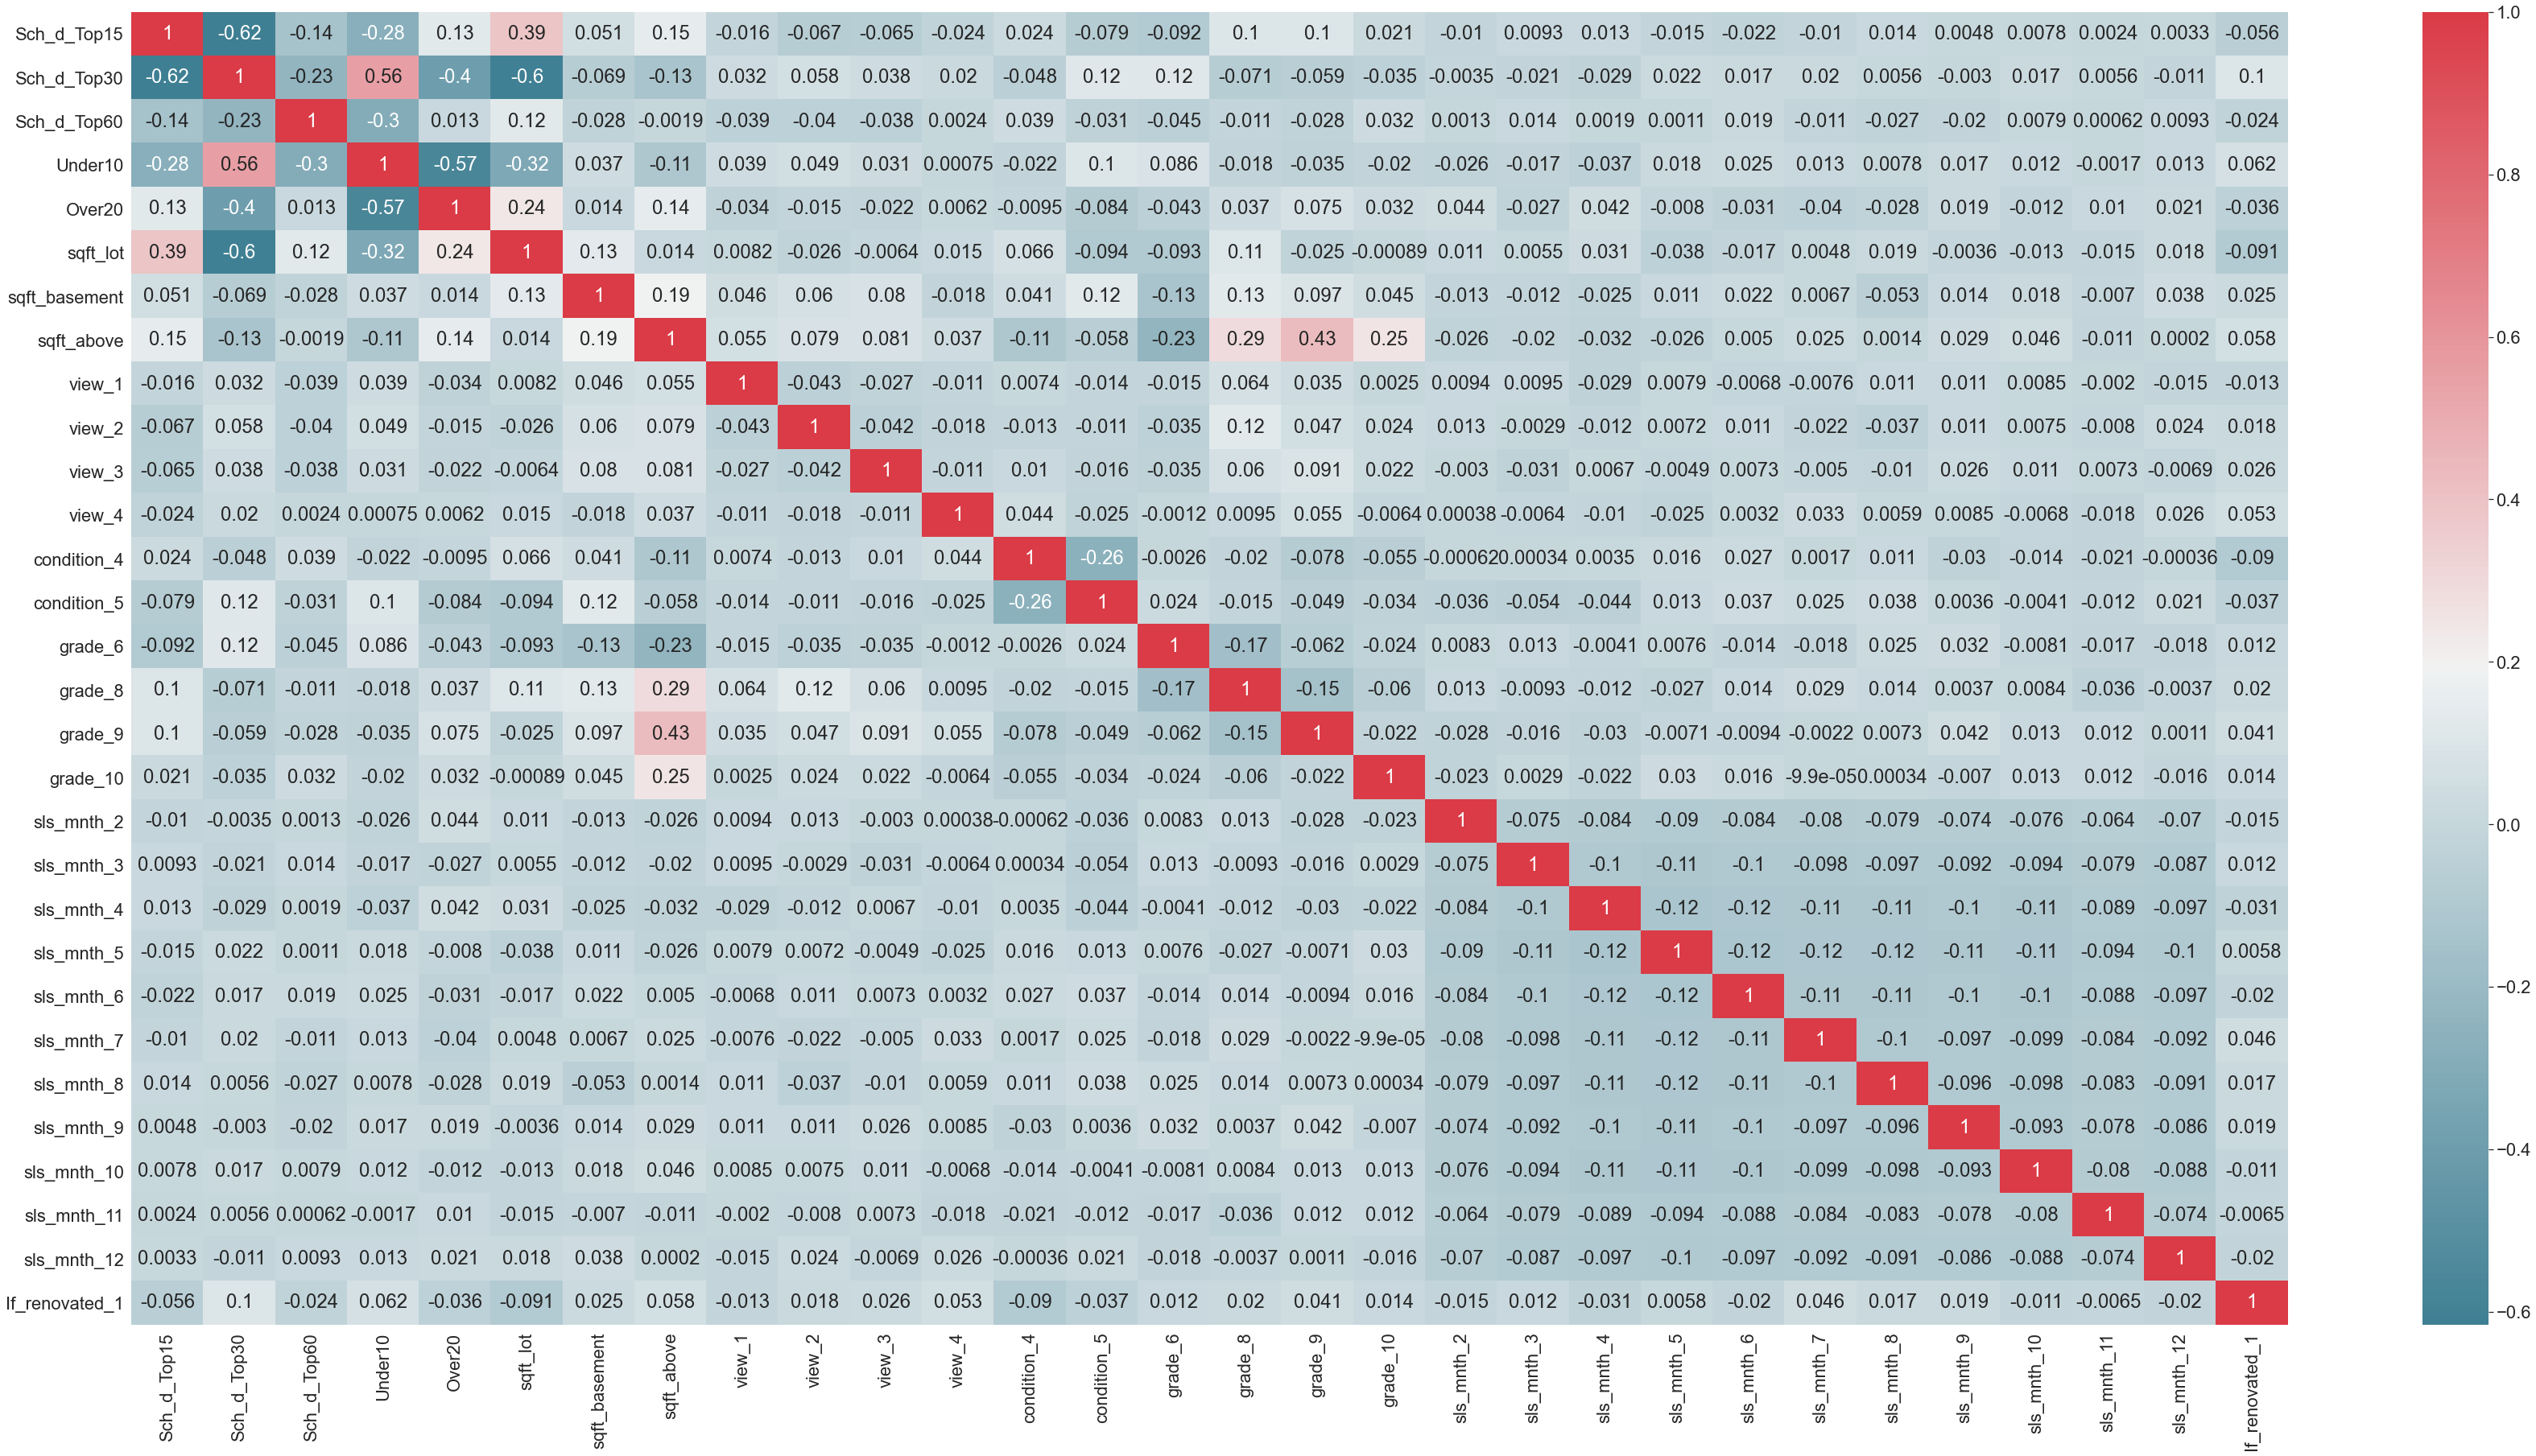

In [381]:
correlation_heatmap(data_Review_Colinearity_Model2)

##     C. Create Pickle of Dataset

In [382]:
FieldsMovingForward = ['id','date', 'price', 'yr_built', 'yr_renovated', 'zipcode', 'lat',
       'long', 'log_price']
FieldsMovingForward.extend(data_Review_Colinearity_Model2.columns)
data_with_Hot_Dist_POints = data_with_Hot_Dist_POints[FieldsMovingForward]

In [383]:
import pickle
# Save
with open('regression_Data_Second_Model.pickle', 'wb') as f:
    pickle.dump(data_with_Hot_Dist_POints, f)

In [384]:
#Create Pickle of minmaxScaler
with open('scaler_2.pickle', 'wb') as f:
    pickle.dump(scaler_2, f)

with open('data_with_Hot_Dist_POints_WithDummies.pickle', 'wb') as f:
    pickle.dump(data_with_Hot_Dist_POints_WithDummies, f)

# with open('model1_Continuous_variables.pickle', 'wb') as f:
#     pickle.dump(model1_Continuous_variables, f)

# <u> <font color='red'>Model 3 Dataset</font> </u>

## A. Adding Features - Previous Year Assesor Values

Add additional previous yr county assessor valuation - AppraisedLandValue, AppraisedImpsValue(aka house value), LandToHouseCheck, InflationSinceLastAppraisal

In [385]:
# Get Data From Above - Build Upon Model 2

# Load Data From Pickel
with open('regression_Data_Second_Model.pickle', 'rb') as file:
    data_Model3 = pickle.load(file)

In [386]:
data_Model3['salesyear'] = pd.DatetimeIndex(data_Model3['date']).year
data_Model3['yearpriortosale'] = data_Model3['salesyear'] - 1
data_Model3["yearpriortosale_str"] = data_Model3["yearpriortosale"].astype('str')
data_Model3["id_str"] = data_Model3["id"].astype('str')
data_Model3['appraisalKey'] = data_Model3['id_str'] + data_Model3['yearpriortosale_str']

#get Appraisal Data - inner join to eleminate valus with no appraisals
df_Appraisal_Info = pd.read_excel('./data/Appraisals_Values_Table_w_3yrRolling.xlsx')
df_Appraisal_Info["appraisalKey"] = df_Appraisal_Info["appraisalKey"].astype('str')

df_Appraisal_Info["AssesorAppraisals_x"] = df_Appraisal_Info['Taxable Land Value']*df_Appraisal_Info['Taxable Imps Value']
df_Appraisal_Info = df_Appraisal_Info[df_Appraisal_Info["AssesorAppraisals_x"]>0]

df_data_with_Appraisals = data_Model3.merge(df_Appraisal_Info[['YrRollingAppraisal','AppraisedLandValue','AppraisedImpsValue','AppraisedTotal','LandToHouseCheck','InflationSinceLastAppraisal','InflationSinceLastAppraisal_abs','AssesorAppraisals_x','Taxable Total','appraisalKey']], on="appraisalKey", how="inner")

df_data_with_Appraisals.drop(['appraisalKey', 'id_str', 'salesyear', 'yearpriortosale_str', 'yearpriortosale'], axis=1, inplace=True)

In [387]:
#Remove addtiaional outliers, "abnarmally" expensive, big, etc. homes 

df_data_with_Appraisals = df_data_with_Appraisals.loc[df_data_with_Appraisals['LandToHouseCheck'] <= .65]
df_data_with_Appraisals = df_data_with_Appraisals.loc[df_data_with_Appraisals['InflationSinceLastAppraisal_abs'] <= .10]
df_data_with_Appraisals = df_data_with_Appraisals.loc[df_data_with_Appraisals['AppraisedTotal'] <= 850000]

# df_data_with_Appraisals = df_data_with_Appraisals.loc[(250000 <= df_data_with_Appraisals['AppraisedTotal']) & (df_data_with_Appraisals['AppraisedTotal'] <= 850000)]


In [388]:
df_data_with_Appraisals.head()

id       date     price  yr_built  yr_renovated  zipcode      lat     long  log_price  Sch_d_Top15  Sch_d_Top30  Sch_d_Top60   Under10  Over20  sqft_lot  sqft_basement  sqft_above  view_1  view_2  view_3  view_4  condition_4  condition_5  grade_6  grade_8  grade_9  grade_10  sls_mnth_2  sls_mnth_3  sls_mnth_4  sls_mnth_5  sls_mnth_6  sls_mnth_7  sls_mnth_8  sls_mnth_9  sls_mnth_10  sls_mnth_11  sls_mnth_12  If_renovated_1  YrRollingAppraisal  AppraisedLandValue  AppraisedImpsValue  AppraisedTotal  LandToHouseCheck  InflationSinceLastAppraisal  InflationSinceLastAppraisal_abs  AssesorAppraisals_x  Taxable Total
1  2487200875  12/9/2014  604000.0      1965           0.0    98136  47.5208 -122.393  13.311329            0            1            0  0.428571    0.05  0.166667       0.419355    0.117450       0       0       0       0            0            1        0        0        0         0           0           0           0           0           0           0           0           0            0            0            1               0              341333              158000              193000          351000          0.450142                     0.086687                         0.086687          30494000000         351000
3  9212900260  5/27/2014  468000.0      1942           0.0    98115  47.6900 -122.292  13.056224            0            1            0  0.500000    0.00  0.333333       0.138249    0.053691       0       0       0       0            1            0        0        0        0         0           0           0           0           1           0           0           0           0            0            0            0               0              376667              243000              156000          399000          0.609023                     0.084239                         0.084239          37908000000         399000
4  9297300055  1/24/2015  650000.0      1979           0.0    98126  47.5714 -122.375  13.384728            0            1            0  0.428571    0.05  0.166667       0.447005    0.429530       0       0       1       0            0            0        0        0        1         0           0           0           0           0           0           0           0           0            0            0            0               0              648000              318000              441000          759000          0.418972                     0.098170                         0.098170         140238000000         759000
7  7955080270  12/3/2014  322500.0      1981           0.0    98058  47.4276 -122.157  12.683858            0            0            1  0.214286    0.05  0.443167       0.359447    0.194631       0       0       0       0            0            0        0        0        0         0           0           0           0           0           0           0           0           0            0            0            1               0              223000              142000               83000          225000          0.631111                     0.013514                         0.013514          11786000000         225000
8  1432701230  7/29/2014  309000.0      1959           0.0    98058  47.4485 -122.175  12.641097            0            0            0  0.214286    0.05  0.942667       0.165899    0.073826       0       0       0       0            1            0        1        0        0         0           0           0           0           0           0           1           0           0            0            0            0               0              172000               65000              111000          176000          0.369318                     0.100000                         0.100000           7215000000         176000

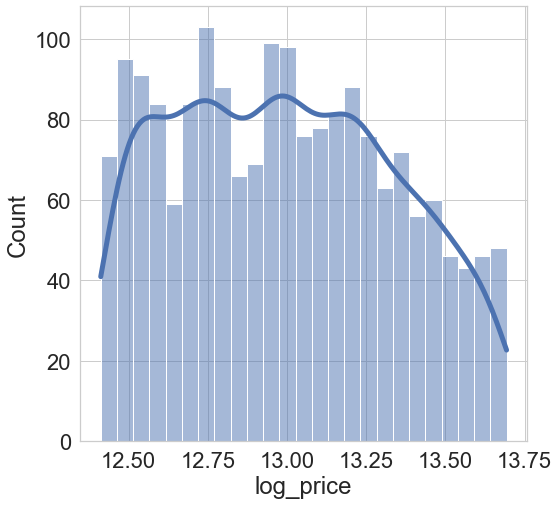

In [389]:
#distribution of Target/ dependent
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
sns.histplot(x= "log_price",
             data=df_data_with_Appraisals,
             bins=25,
             kde=True,
             line_kws={"linewidth":5}, ax=ax, )
plt.show()

##     B. Scaling, Converting & Eliminating Multicolinearity

Prepare To Scale New Features

In [390]:
model3_Continuous_variables  = ['YrRollingAppraisal','AppraisedLandValue', 
                                  'AppraisedImpsValue', 'LandToHouseCheck',
                                  'InflationSinceLastAppraisal', 
                                  'InflationSinceLastAppraisal_abs', 'AppraisedTotal', 'AssesorAppraisals_x']


data_with_Appraisals_Continuous = df_data_with_Appraisals[model3_Continuous_variables]

In [391]:
# Scale new continuous variables
scaled_df_no_index3, scaler_3 = scaleData_min_max (data_with_Appraisals_Continuous)

In [392]:
df_data_with_Appraisals_Not_Scaled = df_data_with_Appraisals.drop(model3_Continuous_variables, axis=1)
df_data_with_Appraisals_Not_Scaled = df_data_with_Appraisals_Not_Scaled.reset_index(drop=True)
df_data_with_Appraisals = pd.concat([df_data_with_Appraisals_Not_Scaled, scaled_df_no_index3], axis=1)

In [393]:
df_data_with_Appraisals.head()

id       date     price  yr_built  yr_renovated  zipcode      lat     long  log_price  Sch_d_Top15  Sch_d_Top30  Sch_d_Top60   Under10  Over20  sqft_lot  sqft_basement  sqft_above  view_1  view_2  view_3  view_4  condition_4  condition_5  grade_6  grade_8  grade_9  grade_10  sls_mnth_2  sls_mnth_3  sls_mnth_4  sls_mnth_5  sls_mnth_6  sls_mnth_7  sls_mnth_8  sls_mnth_9  sls_mnth_10  sls_mnth_11  sls_mnth_12  If_renovated_1  Taxable Total  YrRollingAppraisal  AppraisedLandValue  AppraisedImpsValue  LandToHouseCheck  InflationSinceLastAppraisal  InflationSinceLastAppraisal_abs  AppraisedTotal  AssesorAppraisals_x
0  2487200875  12/9/2014  604000.0      1965           0.0    98136  47.5208 -122.393  13.311329            0            1            0  0.428571    0.05  0.166667       0.419355    0.117450       0       0       0       0            0            1        0        0        0         0           0           0           0           0           0           0           0           0            0            0            1               0         351000            0.422462            0.276284            0.264348          0.601194                     0.932886                         0.866873        0.325137             0.162674
1  9212900260  5/27/2014  468000.0      1942           0.0    98115  47.6900 -122.292  13.056224            0            1            0  0.500000    0.00  0.333333       0.138249    0.053691       0       0       0       0            1            0        0        0        0         0           0           0           0           1           0           0           0           0            0            0            0               0         399000            0.468251            0.484108            0.200000          0.920210                     0.920544                         0.842391        0.390710             0.205829
2  9297300055  1/24/2015  650000.0      1979           0.0    98126  47.5714 -122.375  13.384728            0            1            0  0.428571    0.05  0.166667       0.447005    0.429530       0       0       1       0            0            0        0        0        1         0           0           0           0           0           0           0           0           0            0            0            0               0         759000            0.819870            0.667482            0.695652          0.538607                     0.990773                         0.981697        0.882514             0.801466
3  7955080270  12/3/2014  322500.0      1981           0.0    98058  47.4276 -122.157  12.683858            0            0            1  0.214286    0.05  0.443167       0.359447    0.194631       0       0       0       0            0            0        0        0        0         0           0           0           0           0           0           0           0           0            0            0            1               0         225000            0.269115            0.237164            0.073043          0.964562                     0.563994                         0.135135        0.153005             0.053780
4  1432701230  7/29/2014  309000.0      1959           0.0    98058  47.4485 -122.175  12.641097            0            0            0  0.214286    0.05  0.942667       0.165899    0.073826       0       0       0       0            1            0        1        0        0         0           0           0           0           0           0           1           0           0            0            0            0               0         176000            0.203024            0.048900            0.121739          0.438906                     1.000000                         1.000000        0.086066             0.027173

Check For Colinearity

In [394]:
model1_Categorical_variables

['view_1',
 'view_2',
 'view_3',
 'view_4',
 'condition_4',
 'condition_5',
 'grade_6',
 'grade_8',
 'grade_9',
 'grade_10',
 'sls_mnth_2',
 'sls_mnth_3',
 'sls_mnth_4',
 'sls_mnth_5',
 'sls_mnth_6',
 'sls_mnth_7',
 'sls_mnth_8',
 'sls_mnth_9',
 'sls_mnth_10',
 'sls_mnth_11',
 'sls_mnth_12',
 'If_renovated_1']

In [395]:
# model3_Categorical_variables_to_remove = ['NA']
# model3_Categorical_variables = model2_Categorical_variables
# model3_Categorical_variables = [e for e in model2_Categorical_variables if e not in (model3_Categorical_variables_to_remove)]

model3_Continuous_variables_to_remove = ['NA']
model3_Continuous_variables = [e for e in model3_Continuous_variables if e not in (model3_Continuous_variables_to_remove)]

colstoCheck = model3_Continuous_variables + model2_Categorical_variables + model2_Continuous_variables + model1_Continuous_variables + model1_Categorical_variables

data_Review_Colinearity_Model3 = df_data_with_Appraisals[colstoCheck]
df_fromCheck = checkForColinearity (data_Review_Colinearity_Model3)
df_fromCheck

cc
pairs                                                                   
(AssesorAppraisals_x, AppraisedTotal)                           0.976462
(YrRollingAppraisal, AppraisedTotal)                            0.962037
(YrRollingAppraisal, AssesorAppraisals_x)                       0.943970
(AppraisedImpsValue, AppraisedTotal)                            0.890839
(AppraisedImpsValue, AssesorAppraisals_x)                       0.855704
(AppraisedLandValue, AppraisedTotal)                            0.845262
(AssesorAppraisals_x, AppraisedLandValue)                       0.842029
(YrRollingAppraisal, AppraisedImpsValue)                        0.839890
(AppraisedLandValue, YrRollingAppraisal)                        0.833322
(InflationSinceLastAppraisal_abs, InflationSinceLastAppraisal)  0.726800

In [396]:
vifResults3 = checkForVIF(data_Review_Colinearity_Model3)
vifResults3

[('YrRollingAppraisal', 27.229416656135104),
 ('AppraisedLandValue', 5030.063099935431),
 ('AppraisedImpsValue', 6652.199210051755),
 ('LandToHouseCheck', 10.211087354212244),
 ('InflationSinceLastAppraisal', 2.4530654026931002),
 ('InflationSinceLastAppraisal_abs', 2.2864266291233455),
 ('AppraisedTotal', 18260.112204627174),
 ('AssesorAppraisals_x', 27.327135500738446),
 ('Sch_d_Top15', 2.211492960487343),
 ('Sch_d_Top30', 4.190408723860007),
 ('Sch_d_Top60', 1.3982899706310008),
 ('Under10', 2.905211140175194),
 ('Over20', 2.07468079821961),
 ('sqft_lot', 1.8306114242742575),
 ('sqft_basement', 1.198744897535998),
 ('sqft_above', 2.9029477924363496),
 ('view_1', 1.048988322565638),
 ('view_2', 1.1053225690639499),
 ('view_3', 1.113206801428315),
 ('view_4', 1.0739703352931709),
 ('condition_4', 1.2116776490843135),
 ('condition_5', 1.1670607621351163),
 ('grade_6', 1.153036751628845),
 ('grade_8', 1.5958326368603342),
 ('grade_9', 1.8153261217936587),
 ('grade_10', 1.1842274375571),

In [397]:
model1_Categorical_variables_to_remove = ['waterfront_1']
model1_Categorical_variables = [e for e in model1_Categorical_variables if e not in (model1_Categorical_variables_to_remove)]


model1_Continuous_variables_to_remove_v1 = ['NA']
model1_Continuous_variables = [e for e in model1_Continuous_variables if e not in (model1_Continuous_variables_to_remove_v1)]

# model3_Categorical_variables_to_remove = ['NA']
# model3_Categorical_variables = model2_Categorical_variables
# model3_Categorical_variables = [e for e in model2_Categorical_variables if e not in (model3_Categorical_variables_to_remove)]

model3_Continuous_variables_to_remove = ['YrRollingAppraisal','InflationSinceLastAppraisal_abs','LandToHouseCheck',
                                         'InflationSinceLastAppraisal','AppraisedImpsValue','AppraisedLandValue','AppraisedTotal']
model3_Continuous_variables = [e for e in model3_Continuous_variables if e not in (model3_Continuous_variables_to_remove)]

colstoCheck = model3_Continuous_variables + model2_Categorical_variables + model2_Continuous_variables + model1_Categorical_variables + model1_Continuous_variables 

data_Review_Colinearity_Model3 = df_data_with_Appraisals[colstoCheck]
df_fromCheck = checkForColinearity (data_Review_Colinearity_Model3)
df_fromCheck

Empty DataFrame
Columns: [cc]
Index: []

In [398]:
# data_Review_Colinearity_Model3["AssesorAppraisals"] = data_Review_Colinearity_Model3['AppraisedLandValue']*data_Review_Colinearity_Model3['AppraisedImpsValue']
# data_Review_Colinearity_Model3 = data_Review_Colinearity_Model3.drop(['AppraisedLandValue','AppraisedImpsValue'], axis=1)
# df_data_with_Appraisals["AssesorAppraisals"] = data_Review_Colinearity_Model3["AssesorAppraisals"]

In [399]:
vifResults3 = checkForVIF(data_Review_Colinearity_Model3)
vifResults3

[('AssesorAppraisals_x', 6.294572609227828),
 ('Sch_d_Top15', 2.112412803691003),
 ('Sch_d_Top30', 6.088975315110999),
 ('Sch_d_Top60', 1.323321940786265),
 ('Under10', 9.65497974074645),
 ('Over20', 2.6388553902575516),
 ('view_1', 1.0655934450914184),
 ('view_2', 1.1432310794375111),
 ('view_3', 1.1169678076635405),
 ('view_4', 1.0532697636854895),
 ('condition_4', 1.7437128456099054),
 ('condition_5', 1.299951650244402),
 ('grade_6', 1.1425260224617027),
 ('grade_8', 2.0459156800431484),
 ('grade_9', 1.7959183061110382),
 ('grade_10', 1.1532213568121092),
 ('sls_mnth_2', 1.8571229568551415),
 ('sls_mnth_3', 2.1558948558598328),
 ('sls_mnth_4', 2.588756636250859),
 ('sls_mnth_5', 2.6372334086001312),
 ('sls_mnth_6', 2.5346950229136787),
 ('sls_mnth_7', 2.3816060532214434),
 ('sls_mnth_8', 2.2859179136262293),
 ('sls_mnth_9', 2.2343117121623006),
 ('sls_mnth_10', 2.45356435816948),
 ('sls_mnth_11', 2.070367030755835),
 ('sls_mnth_12', 2.1219266487762956),
 ('If_renovated_1', 1.0788065

In [400]:
data_Review_Colinearity_Model3.describe()

AssesorAppraisals_x  Sch_d_Top15  Sch_d_Top30  Sch_d_Top60      Under10       Over20       view_1       view_2       view_3       view_4  condition_4  condition_5      grade_6      grade_8      grade_9     grade_10   sls_mnth_2   sls_mnth_3   sls_mnth_4   sls_mnth_5   sls_mnth_6   sls_mnth_7   sls_mnth_8   sls_mnth_9  sls_mnth_10  sls_mnth_11  sls_mnth_12  If_renovated_1     sqft_lot  sqft_basement   sqft_above
count          1841.000000  1841.000000  1841.000000  1841.000000  1841.000000  1841.000000  1841.000000  1841.000000  1841.000000  1841.000000  1841.000000  1841.000000  1841.000000  1841.000000  1841.000000  1841.000000  1841.000000  1841.000000  1841.000000  1841.000000  1841.000000  1841.000000  1841.000000  1841.000000  1841.000000  1841.000000  1841.000000     1841.000000  1841.000000    1841.000000  1841.000000
mean              0.180597     0.216730     0.455731     0.060293     0.351866     0.085144     0.027702     0.065182     0.029875     0.005432     0.330255     0.107007     0.048343     0.290060     0.059750     0.007605     0.055948     0.079848     0.108093     0.112439     0.102118     0.092341     0.088539     0.081477     0.092884     0.070614     0.073330        0.030418     0.493091       0.331767     0.239308
std               0.156193     0.412129     0.498172     0.238094     0.191561     0.106911     0.164163     0.246914     0.170289     0.073520     0.470433     0.309206     0.214549     0.453913     0.237088     0.086896     0.229883     0.271131     0.310583     0.315991     0.302886     0.289586     0.284154     0.273641     0.290349     0.256248     0.260748        0.171782     0.278096       0.146440     0.154466
min               0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000        0.000000     0.000000       0.000000     0.000000
25%               0.063140     0.000000     0.000000     0.000000     0.142857     0.050000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000        0.000000     0.250000       0.221198     0.134228
50%               0.131335     0.000000     0.000000     0.000000     0.357143     0.050000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000        0.000000     0.530667       0.322581     0.208054
75%               0.244479     0.000000     1.000000     0.000000     0.500000     0.100000     0.000000     0.000000     0.000000     0.000000     1.000000     0.000000     0.000000     1.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000        0.000000     0.706667       0.419355     0.302013
max               1.000000     1.000000     1.000000     1.000000     1.000000     0.900000     1.000000     1.000000     1.000000     1.000000     1.000000     1.000000     1.000000     1.000000     1.000000     1.000000     1.000000     1.000000     1.000000     1.000000     1.000000     1.000000     1.000000     1.000000     1.000000     1.000000     1.000000        1.000000     1.000000       0.889401     1.000000

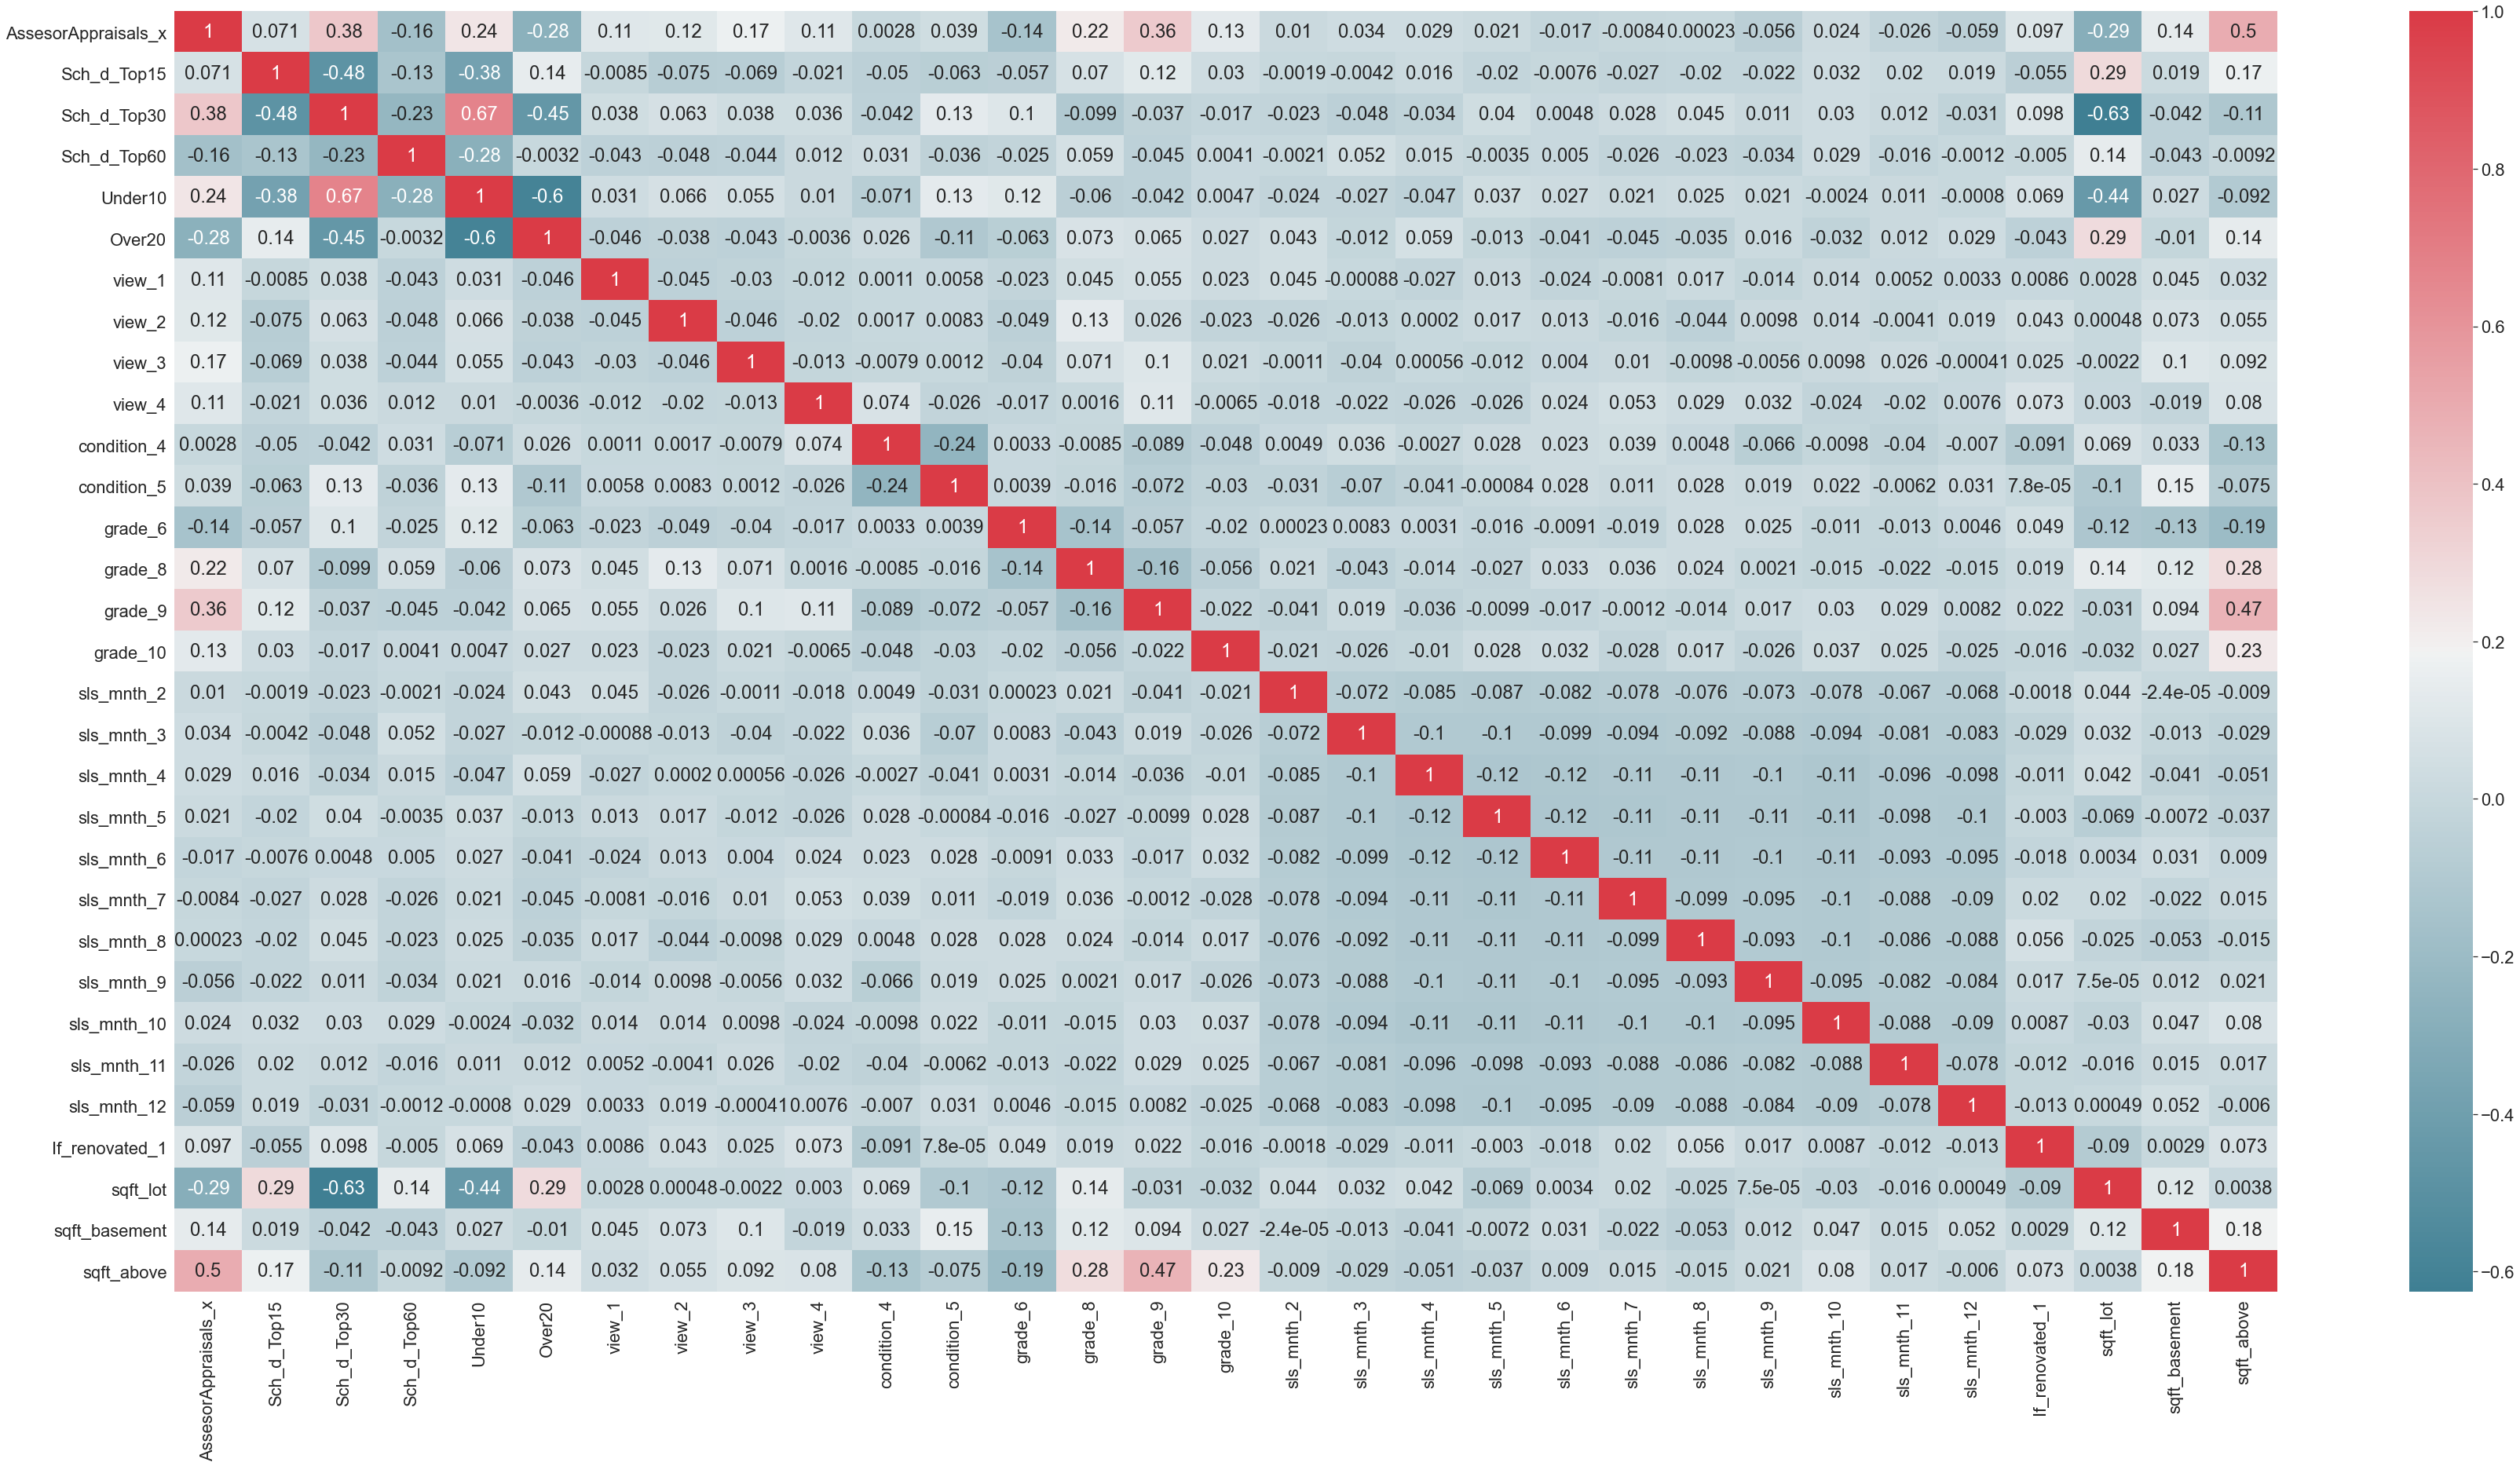

In [401]:
correlation_heatmap(data_Review_Colinearity_Model3)

## C. Create Pickle of Dataset

In [402]:
FieldsMovingForward = ['id','date', 'price', 'yr_built', 'yr_renovated', 'zipcode', 'lat',
       'long', 'log_price']
FieldsMovingForward.extend(data_Review_Colinearity_Model3.columns)
df_data_with_Appraisals = df_data_with_Appraisals[FieldsMovingForward]

In [403]:
import pickle
# Save
with open('regression_Data_Third_Model.pickle', 'wb') as f:
    pickle.dump(df_data_with_Appraisals, f)

In [404]:
#Create Pickle of minmaxScaler
with open('scaler_3.pickle', 'wb') as f:
    pickle.dump(scaler_3, f)

with open('df_data_with_Appraisals.pickle', 'wb') as f:
    pickle.dump(df_data_with_Appraisals, f)

# Ensure linearity of features(independent) to target(dependent)

In [ ]:
data_No_Outliers["price"].describe().apply("${0:,.0f}".format)
#"Average" - middle class houses between 367k& 638$k

In [ ]:
data_pred = data_No_Outliers[['YrRollingAppraisal','AppraisedLandValue', 'AppraisedImpsValue', 'LandToHouseCheck',
       'InflationSinceLastAppraisal','bedrooms', 'bathrooms', 'sqft_living',
                                          'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
                                          'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15','YearsSinceRenovation', 'AgeOfHome', 
                                          'price', 'HotnessScore', 'State Rank','#1Attractions', 
                                          '#2Attractions', '#3Attractions']]

plt.figure(figsize=(60,40), facecolor="white")
sns.set(font_scale=2)

for index, column in enumerate(data_pred):

    if column != "price":
        ax = plt.subplot(6, 5, index+1)
        sns.regplot(x=column, y="price", data=data_No_Outliers, ax=ax, label='medium', line_kws={"color": "red"});
        plt.ticklabel_format(style='plain', axis='both')
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
    
plt.show();
